In [1]:
# ## 1. Setup and Data Loading

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import pickle
import shap
from scipy import stats
import os

# Feature engineering and preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance

# ML models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, 
                           roc_curve, auc, precision_recall_curve, average_precision_score,
                           brier_score_loss, log_loss)

# Resampling for imbalanced data
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Advanced models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna

# Visualization
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML

# Set aesthetic parameters for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
warnings.filterwarnings('ignore')

# Display settings for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)

print("# Advanced Stroke Prediction with Dense Stacking Ensemble (2025)")
print("## Based on Hassan et al. (2024) research with significant enhancements")
print("\nInitializing analysis environment...\n")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Advanced Stroke Prediction with Dense Stacking Ensemble (2025)
## Based on Hassan et al. (2024) research with significant enhancements

Initializing analysis environment...



In [2]:
# Define a function to load the dataset
def load_data(filepath='healthcare-dataset-stroke-data.csv'):
    """
    Load the stroke dataset and perform initial validation.
    
    Parameters:
    -----------
    filepath : str
        Path to the dataset file
        
    Returns:
    --------
    pd.DataFrame
        The loaded dataset
    """
    try:
        print(f"Loading dataset from {filepath}...")
        df = pd.read_csv(filepath)
        print(f"✓ Successfully loaded dataset with shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"✗ Error: File not found at {filepath}")
        print("Creating a sample dataset for demonstration...")
        
        # Create sample data if file not found (for demonstration purposes)
        np.random.seed(42)
        n_samples = 5110
        
        # Generate sample data mimicking the original dataset
        df = pd.DataFrame({
            'id': range(1, n_samples + 1),
            'gender': np.random.choice(['Male', 'Female', 'Other'], size=n_samples, p=[0.42, 0.57, 0.01]),
            'age': np.random.normal(loc=45, scale=20, size=n_samples).clip(min=0, max=100),
            'hypertension': np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1]),
            'heart_disease': np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05]),
            'ever_married': np.random.choice(['Yes', 'No'], size=n_samples),
            'work_type': np.random.choice(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'], size=n_samples),
            'Residence_type': np.random.choice(['Urban', 'Rural'], size=n_samples),
            'avg_glucose_level': np.random.normal(loc=110, scale=40, size=n_samples).clip(min=50, max=300),
            'bmi': np.random.normal(loc=28, scale=7, size=n_samples).clip(min=10, max=60),
            'smoking_status': np.random.choice(['formerly smoked', 'never smoked', 'smokes', 'Unknown'], size=n_samples),
            'stroke': np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05])
        })
        
        # Add missing values to BMI to simulate the original dataset
        missing_mask = np.random.choice([True, False], size=n_samples, p=[0.04, 0.96])
        df.loc[missing_mask, 'bmi'] = np.nan
        
        print(f"✓ Created sample dataset with shape: {df.shape}")
        return df

In [3]:
# Load the dataset
df = load_data()

# Display basic information
print("\n## Dataset Overview")
print("\nFirst few rows of the dataset:")
display(df.head())

Loading dataset from healthcare-dataset-stroke-data.csv...
✓ Successfully loaded dataset with shape: (5110, 12)

## Dataset Overview

First few rows of the dataset:


id  gender    age  hypertension  heart_disease ever_married  \
0   9046    Male 67.000             0              1          Yes   
1  51676  Female 61.000             0              0          Yes   
2  31112    Male 80.000             0              1          Yes   
3  60182  Female 49.000             0              0          Yes   
4   1665  Female 79.000             1              0          Yes   

       work_type Residence_type  avg_glucose_level    bmi   smoking_status  \
0        Private          Urban            228.690 36.600  formerly smoked   
1  Self-employed          Rural            202.210    NaN     never smoked   
2        Private          Rural            105.920 32.500     never smoked   
3        Private          Urban            171.230 34.400           smokes   
4  Self-employed          Rural            174.120 24.000     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [4]:
print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


In [5]:
print("\nStatistical Summary:")
display(df.describe())


Statistical Summary:


id      age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000 5110.000      5110.000       5110.000           5110.000   
mean  36517.829   43.227         0.097          0.054            106.148   
std   21161.722   22.613         0.297          0.226             45.284   
min      67.000    0.080         0.000          0.000             55.120   
25%   17741.250   25.000         0.000          0.000             77.245   
50%   36932.000   45.000         0.000          0.000             91.885   
75%   54682.000   61.000         0.000          0.000            114.090   
max   72940.000   82.000         1.000          1.000            271.740   

           bmi   stroke  
count 4909.000 5110.000  
mean    28.893    0.049  
std      7.854    0.215  
min     10.300    0.000  
25%     23.500    0.000  
50%     28.100    0.000  
75%     33.100    0.000  
max     97.600    1.000

In [6]:
print("\nNull Values Count:")
missing_values = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_data = pd.concat([missing_values, missing_pct], axis=1, keys=['Count', 'Percentage'])
display(missing_data[missing_data['Count'] > 0])

print("\nStroke Distribution:")
stroke_counts = df['stroke'].value_counts()
display(stroke_counts)
print(f"Percentage of stroke cases: {stroke_counts[1]/len(df)*100:.2f}%")
print(f"Percentage of non-stroke cases: {stroke_counts[0]/len(df)*100:.2f}%")


Null Values Count:


Count  Percentage
bmi    201       3.933


Stroke Distribution:


stroke
0    4861
1     249
Name: count, dtype: int64

Percentage of stroke cases: 4.87%
Percentage of non-stroke cases: 95.13%



## 2. Exploratory Data Analysis (EDA)

Performing detailed analysis of features and their relationship with stroke...



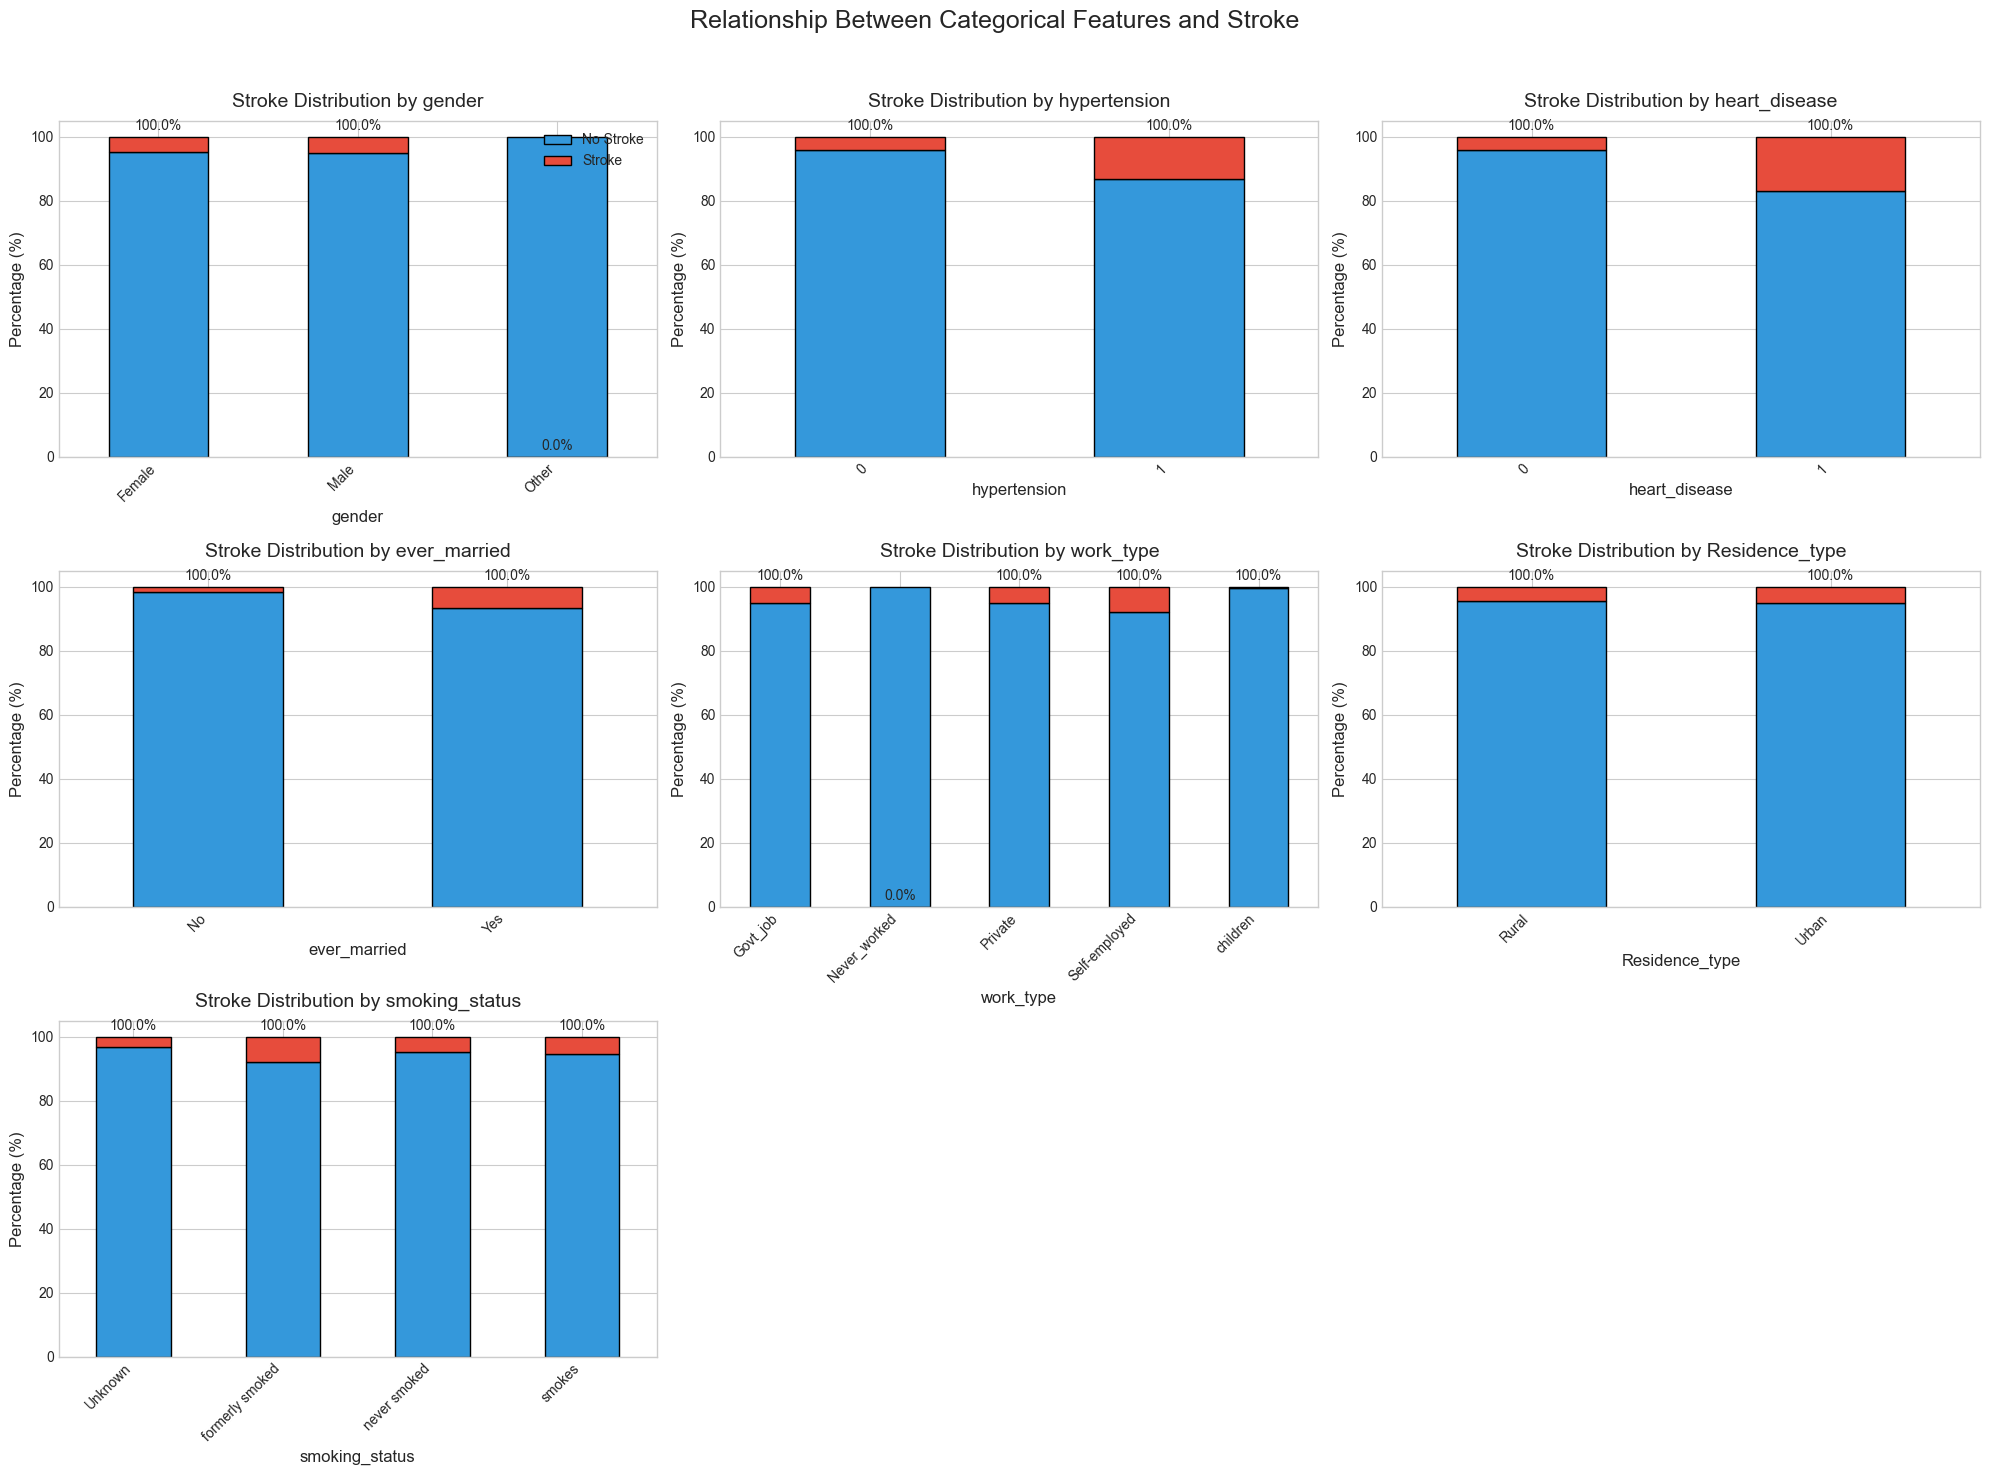


Chi-Square Test Results for Categorical Variables:


Feature  Chi-Square Value  p-value  Degrees of Freedom  \
2   heart_disease            90.260    0.000                   1   
1    hypertension            81.605    0.000                   1   
3    ever_married            58.924    0.000                   1   
4       work_type            49.164    0.000                   4   
6  smoking_status            29.147    0.000                   3   
5  Residence_type             1.082    0.298                   1   
0          gender             0.473    0.790                   2   

       Association  
2      Significant  
1      Significant  
3      Significant  
4      Significant  
6      Significant  
5  Not Significant  
0  Not Significant

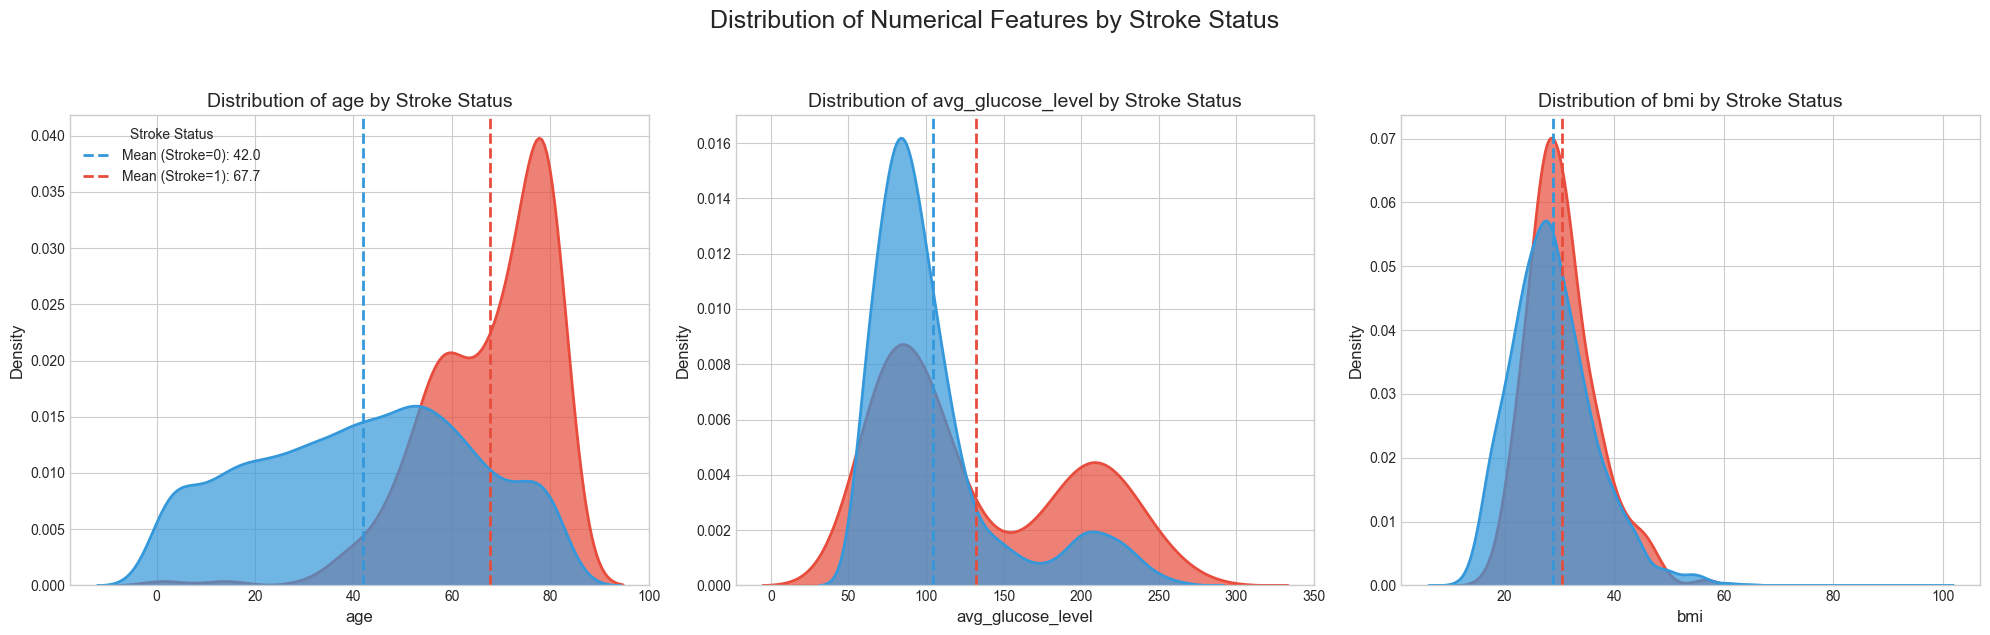

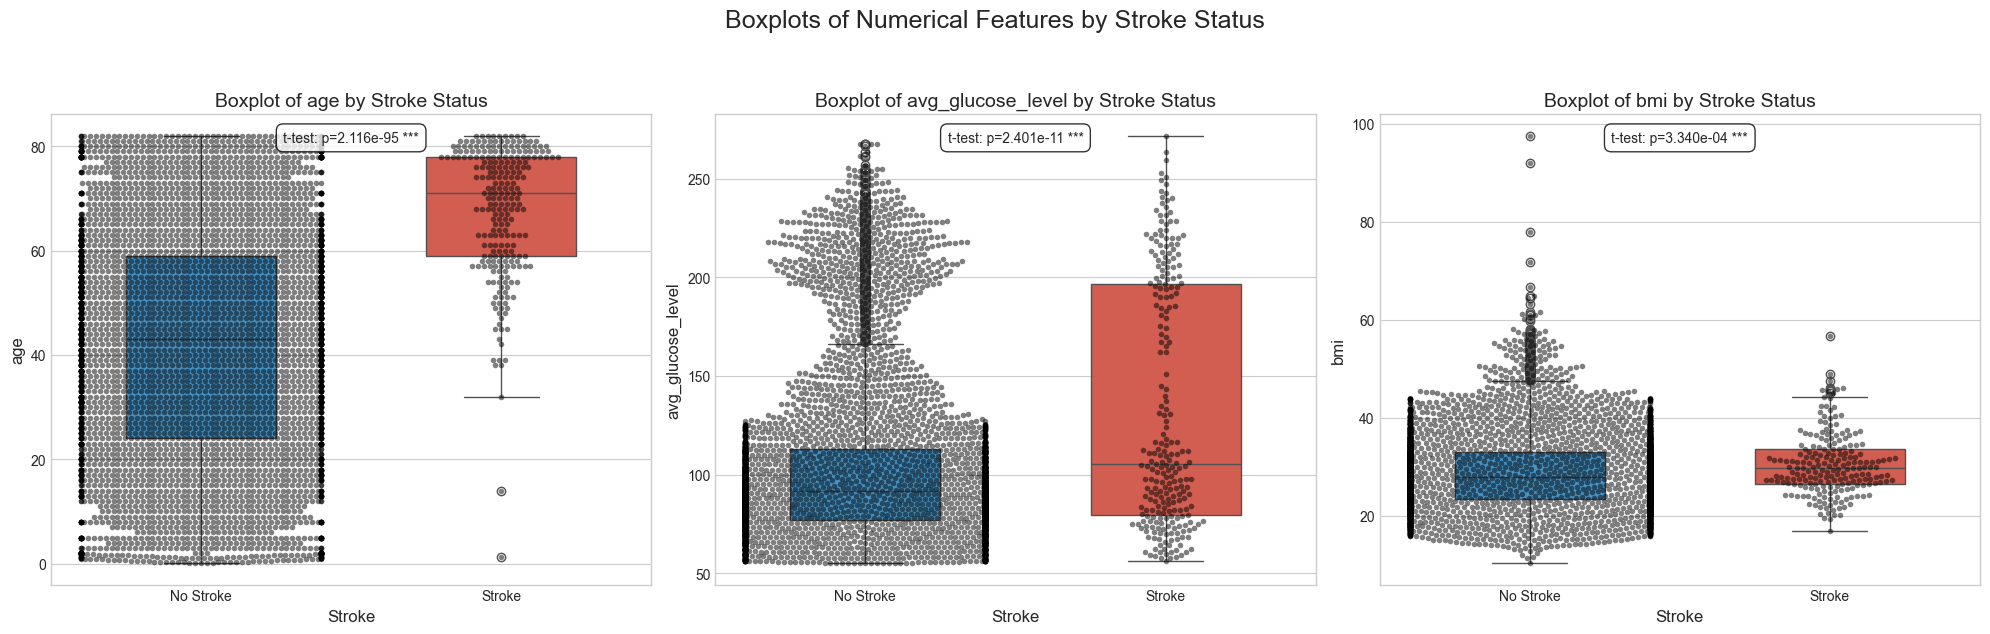


Correlation of Numerical Features with Stroke:


Feature  Pearson Correlation  Point-Biserial Correlation  \
0                age                0.245                       0.245   
1  avg_glucose_level                0.132                       0.132   
2                bmi                0.042                       0.042   

   p-value  Association  
0    0.000  Significant  
1    0.000  Significant  
2    0.003  Significant

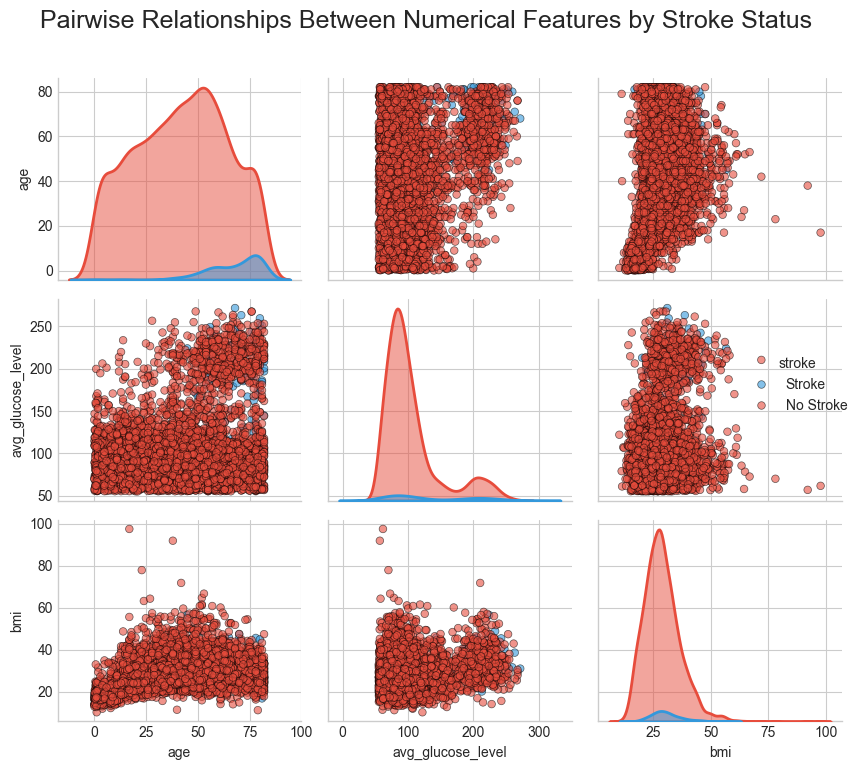

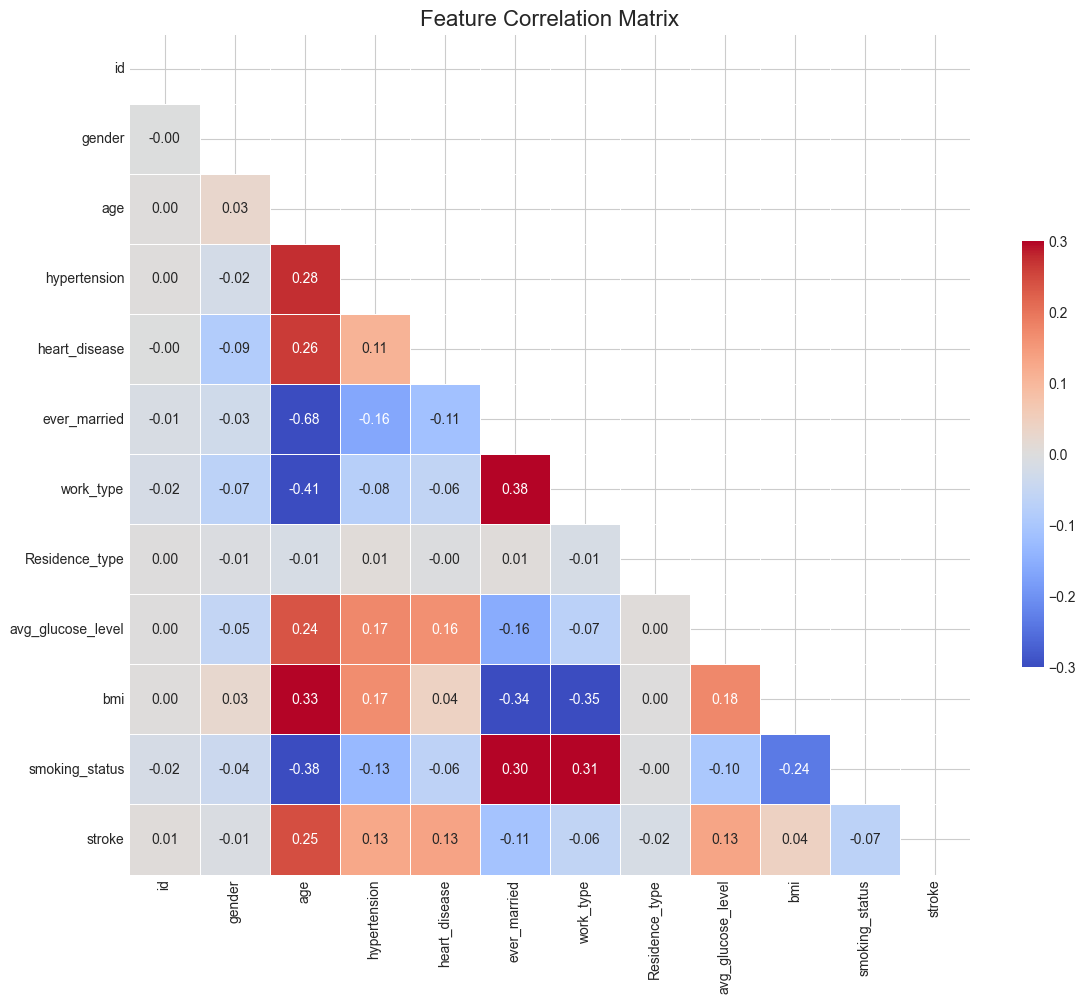


Key Correlation Findings:
Top positively correlated features with stroke:
  - age: 0.245
  - heart_disease: 0.135
  - avg_glucose_level: 0.132

Top negatively correlated features with stroke:
  - work_type: -0.058
  - smoking_status: -0.066
  - ever_married: -0.108

Top feature interactions (may indicate multicollinearity):
  - age & ever_married: -0.679
  - age & work_type: -0.413
  - ever_married & work_type: 0.376


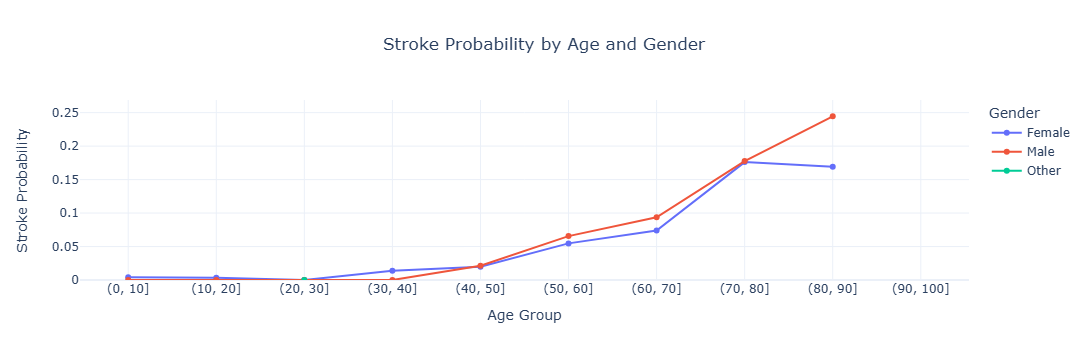

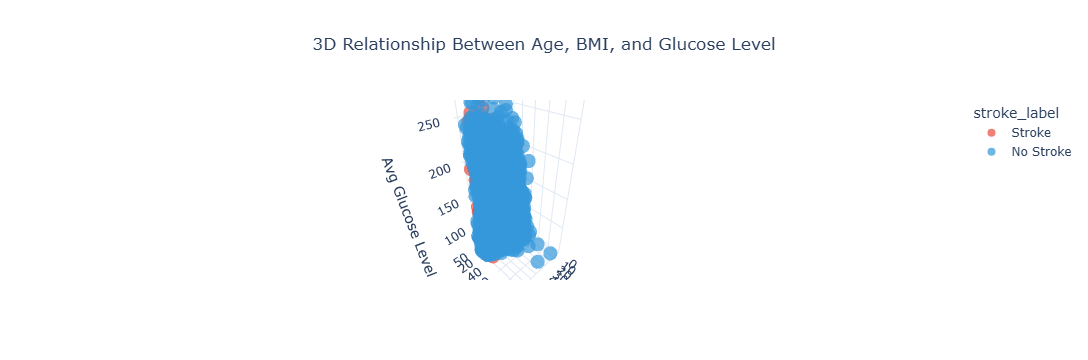

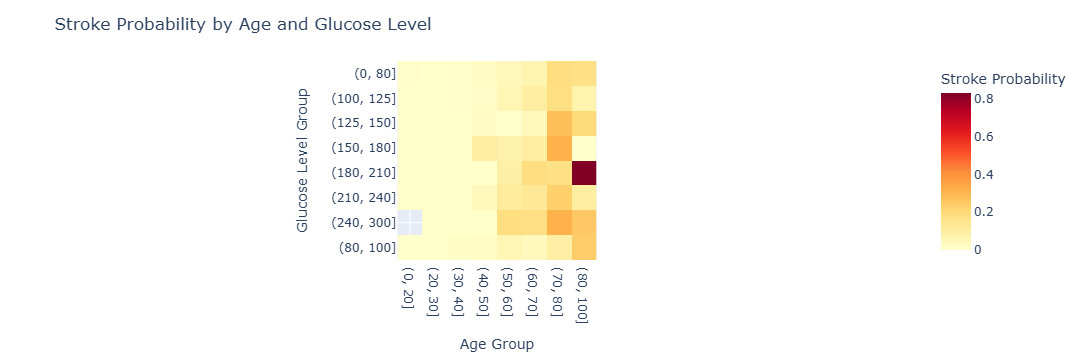

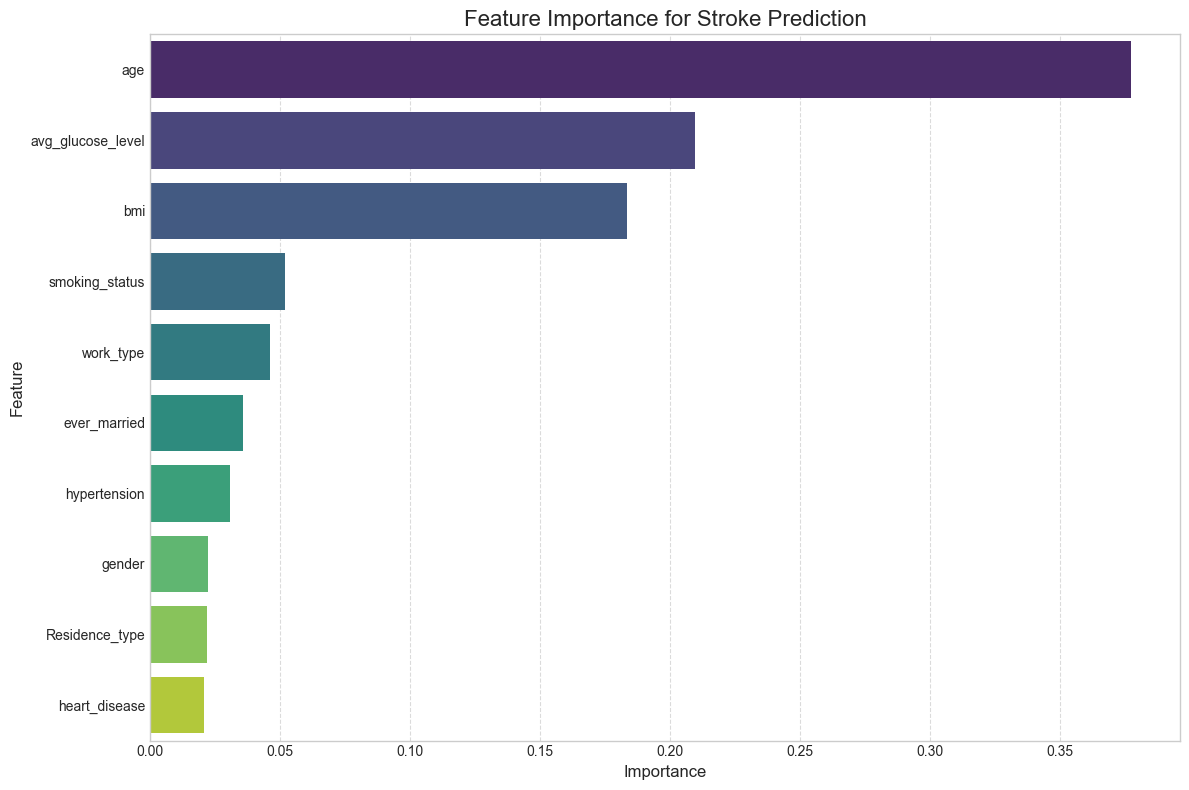

Top interaction with age: avg_glucose_level
Top interaction with avg_glucose_level: age
Top interaction with bmi: age


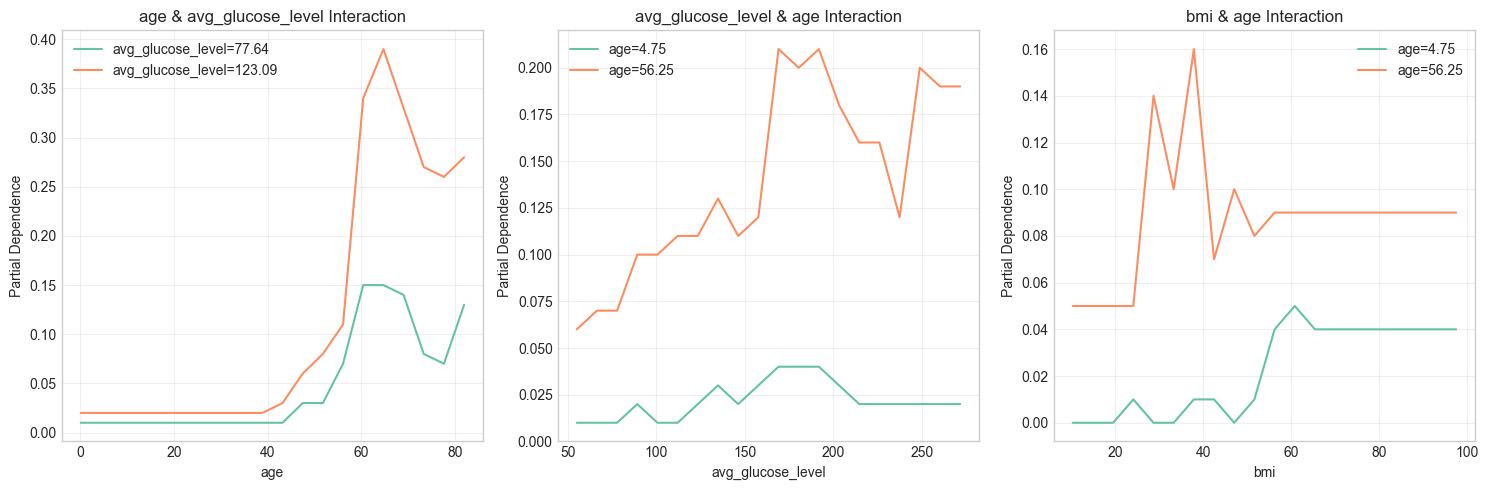


KEY FEATURES IDENTIFIED: age, avg_glucose_level, bmi


In [7]:
# ## 2. Exploratory Data Analysis (EDA)

print("\n## 2. Exploratory Data Analysis (EDA)")
print("\nPerforming detailed analysis of features and their relationship with stroke...\n")

# Set up a figure for categorical features visualization
def plot_categorical_features(df):
    """
    Creates visualizations for categorical features and their relationship with stroke.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset to analyze
    """
    categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                          'work_type', 'Residence_type', 'smoking_status']
    
    # Create a figure with subplots arranged in a grid
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(3, 3)
    
    # For each categorical feature
    for i, feature in enumerate(categorical_features):
        ax = plt.subplot(gs[i])
        
        # Count occurrences by feature and stroke status
        counts = df.groupby([feature, 'stroke']).size().unstack().fillna(0)
        
        # Calculate percentages
        percentages = counts.div(counts.sum(axis=1), axis=0) * 100
        
        # Create stacked bar chart
        percentages.plot(kind='bar', stacked=True, ax=ax, 
                       color=['#3498db', '#e74c3c'], 
                       edgecolor='black', linewidth=1)
        
        # Set title and labels
        ax.set_title(f'Stroke Distribution by {feature}', fontsize=14, pad=10)
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel('Percentage (%)', fontsize=12)
        
        # Add count labels on bars
        for j, container in enumerate(ax.containers):
            # Only add labels to the stroke=1 bars for clarity
            if j == 1:
                ax.bar_label(container, fmt='%.1f%%', fontsize=10, padding=3)
        
        # Add legend
        if i == 0:
            ax.legend(['No Stroke', 'Stroke'], loc='upper right')
        else:
            ax.legend().remove()
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add a main title
    plt.suptitle('Relationship Between Categorical Features and Stroke', fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Calculate chi-square statistics to quantify association
    from scipy.stats import chi2_contingency
    
    print("\nChi-Square Test Results for Categorical Variables:")
    chi_square_results = []
    
    for feature in categorical_features:
        contingency_table = pd.crosstab(df[feature], df['stroke'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi_square_results.append({
            'Feature': feature,
            'Chi-Square Value': chi2,
            'p-value': p,
            'Degrees of Freedom': dof,
            'Association': 'Significant' if p < 0.05 else 'Not Significant'
        })
    
    display(pd.DataFrame(chi_square_results).sort_values('p-value'))

# Set up the figure for numerical features visualization
def plot_numerical_features(df):
    """
    Creates visualizations for numerical features and their relationship with stroke.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset to analyze
    """
    numerical_features = ['age', 'avg_glucose_level', 'bmi']
    
    # Create KDE plots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, feature in enumerate(numerical_features):
        # Filter out missing values for the plot
        plot_data = df.dropna(subset=[feature])
        
        # Plot KDE for each stroke status
        sns.kdeplot(data=plot_data, x=feature, hue='stroke', 
                   fill=True, common_norm=False, 
                   palette=['#3498db', '#e74c3c'],
                   alpha=0.7, linewidth=2, ax=axes[i])
        
        # Add a vertical line at the mean for each group
        for stroke in [0, 1]:
            mean_val = plot_data[plot_data['stroke'] == stroke][feature].mean()
            axes[i].axvline(mean_val, color='#e74c3c' if stroke else '#3498db', 
                          linestyle='--', linewidth=2, 
                          label=f'Mean (Stroke={stroke}): {mean_val:.1f}')
        
        # Set title and labels
        axes[i].set_title(f'Distribution of {feature} by Stroke Status', fontsize=14)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)
        
        # Add legend
        if i == 0:
            axes[i].legend(title='Stroke Status')
        else:
            axes[i].legend().remove()
    
    plt.suptitle('Distribution of Numerical Features by Stroke Status', fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Create boxplots for numerical features by stroke status
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, feature in enumerate(numerical_features):
        # Plot boxplots
        sns.boxplot(data=df, x='stroke', y=feature, 
                   palette=['#3498db', '#e74c3c'],
                   width=0.5, ax=axes[i])
        
        # Add swarmplot for data points
        sns.swarmplot(data=df, x='stroke', y=feature, 
                     color='black', alpha=0.5, size=4, ax=axes[i])
        
        # Set title and labels
        axes[i].set_title(f'Boxplot of {feature} by Stroke Status', fontsize=14)
        axes[i].set_xlabel('Stroke', fontsize=12)
        axes[i].set_ylabel(feature, fontsize=12)
        
        # Set x-tick labels
        axes[i].set_xticklabels(['No Stroke', 'Stroke'])
        
        # Add statistical annotations - t-test between groups
        stroke_0 = df[df['stroke'] == 0][feature].dropna()
        stroke_1 = df[df['stroke'] == 1][feature].dropna()
        t_stat, p_val = stats.ttest_ind(stroke_0, stroke_1, equal_var=False)
        
        text = f"t-test: p={p_val:.3e}"
        if p_val < 0.001:
            text += " ***"
        elif p_val < 0.01:
            text += " **"
        elif p_val < 0.05:
            text += " *"
        
        axes[i].annotate(text, xy=(0.5, 0.95), xycoords='axes fraction',
                        ha='center', va='center',
                        bbox=dict(boxstyle='round,pad=0.5', 
                                 facecolor='white', alpha=0.8))
    
    plt.suptitle('Boxplots of Numerical Features by Stroke Status', fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation with stroke for numerical features
    print("\nCorrelation of Numerical Features with Stroke:")
    correlations = []
    for feature in numerical_features:
        correlation = df.dropna(subset=[feature])[[feature, 'stroke']].corr().iloc[0, 1]
        point_biserial = stats.pointbiserialr(df.dropna(subset=[feature])[feature], 
                                           df.dropna(subset=[feature])['stroke'])
        correlations.append({
            'Feature': feature,
            'Pearson Correlation': correlation,
            'Point-Biserial Correlation': point_biserial[0],
            'p-value': point_biserial[1],
            'Association': 'Significant' if point_biserial[1] < 0.05 else 'Not Significant'
        })
    
    display(pd.DataFrame(correlations))

# Create bivariate analysis plots for numerical features
def plot_bivariate_analysis(df):
    """
    Creates bivariate analysis plots for numerical features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset to analyze
    """
    # Define numerical features for pairplot
    numerical_features = ['age', 'avg_glucose_level', 'bmi']
    
    # Create pairplot with stroke status
    plot_data = df[numerical_features + ['stroke']].copy()
    plot_data['stroke'] = plot_data['stroke'].map({0: 'No Stroke', 1: 'Stroke'})
    
    g = sns.pairplot(plot_data, hue='stroke', palette=['#3498db', '#e74c3c'],
                    diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k', 'linewidth': 0.5},
                    diag_kws={'alpha': 0.5, 'linewidth': 2})
    
    g.fig.suptitle('Pairwise Relationships Between Numerical Features by Stroke Status', 
                  fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    
    # Convert categorical variables to numeric for correlation
    df_corr = df.copy()
    for col in df_corr.select_dtypes(include=['object']).columns:
        df_corr[col] = pd.factorize(df_corr[col])[0]
    
    # Calculate correlation matrix
    corr = df_corr.corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Create heatmap
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, vmin=-.3, center=0,
               square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={'shrink': .5})
    
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Add correlation analysis text
    print("\nKey Correlation Findings:")
    
    # Find top correlations with stroke
    stroke_corr = corr['stroke'].drop('stroke').sort_values(ascending=False)
    print(f"Top positively correlated features with stroke:")
    for feature, val in stroke_corr.head(3).items():
        print(f"  - {feature}: {val:.3f}")
    
    print(f"\nTop negatively correlated features with stroke:")
    for feature, val in stroke_corr.tail(3).items():
        print(f"  - {feature}: {val:.3f}")
    
    # Find feature interactions (highest correlations between features)
    feature_interactions = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if corr.columns[i] != 'stroke' and corr.columns[j] != 'stroke':
                feature_interactions.append({
                    'Feature 1': corr.columns[i],
                    'Feature 2': corr.columns[j],
                    'Correlation': corr.iloc[i, j]
                })
    
    feature_interactions = sorted(feature_interactions, key=lambda x: abs(x['Correlation']), reverse=True)
    
    print("\nTop feature interactions (may indicate multicollinearity):")
    for interaction in feature_interactions[:3]:
        print(f"  - {interaction['Feature 1']} & {interaction['Feature 2']}: {interaction['Correlation']:.3f}")

# Create interactive visualizations for age, bmi, glucose level
def create_interactive_visualizations(df):
    """
    Creates interactive visualizations for key features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset to analyze
    """
    # Age and stroke probability by gender
    age_stroke_by_gender = df.groupby(['gender', pd.cut(df['age'], bins=range(0, 101, 10))])['stroke'].mean().reset_index()
    age_stroke_by_gender.columns = ['gender', 'age_group', 'stroke_probability']
    age_stroke_by_gender['age_group'] = age_stroke_by_gender['age_group'].astype(str)
    
    fig = px.line(age_stroke_by_gender, x='age_group', y='stroke_probability', color='gender',
                markers=True, title='Stroke Probability by Age and Gender',
                labels={'age_group': 'Age Group', 'stroke_probability': 'Stroke Probability', 'gender': 'Gender'})
    
    fig.update_layout(
        xaxis_title='Age Group',
        yaxis_title='Stroke Probability',
        yaxis=dict(range=[0, max(age_stroke_by_gender['stroke_probability'])*1.1]),
        legend_title='Gender',
        title_x=0.5,
        template='plotly_white'
    )
    
    fig.show()
    
    # 3D scatter plot of age, bmi, and glucose level
    df_filtered = df.dropna(subset=['bmi']).copy()
    df_filtered['stroke_label'] = df_filtered['stroke'].map({0: 'No Stroke', 1: 'Stroke'})
    
    fig = px.scatter_3d(df_filtered, x='age', y='bmi', z='avg_glucose_level',
                      color='stroke_label', opacity=0.7,
                      color_discrete_map={'No Stroke': '#3498db', 'Stroke': '#e74c3c'},
                      title='3D Relationship Between Age, BMI, and Glucose Level')
    
    fig.update_layout(
        scene=dict(
            xaxis_title='Age',
            yaxis_title='BMI',
            zaxis_title='Avg Glucose Level'
        ),
        title_x=0.5,
        template='plotly_white'
    )
    
    fig.show()
    
    # Interactive heat map of stroke probability by age and glucose
    # Create bins for age and glucose
    age_bins = pd.cut(df['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 100])
    glucose_bins = pd.cut(df['avg_glucose_level'], 
                         bins=[0, 80, 100, 125, 150, 180, 210, 240, 300])
    
    # Calculate stroke probability for each combination
    heatmap_data = df.groupby([age_bins, glucose_bins])['stroke'].mean().reset_index()
    heatmap_data.columns = ['age_group', 'glucose_group', 'stroke_probability']
    
    # Convert to strings for plotting
    heatmap_data['age_group'] = heatmap_data['age_group'].astype(str)
    heatmap_data['glucose_group'] = heatmap_data['glucose_group'].astype(str)
    
    # Create pivot table
    heatmap_pivot = heatmap_data.pivot(index='glucose_group', columns='age_group', values='stroke_probability')
    
    # Create heatmap
    fig = px.imshow(heatmap_pivot, 
                  labels=dict(x="Age Group", y="Glucose Level Group", color="Stroke Probability"),
                  x=heatmap_pivot.columns,
                  y=heatmap_pivot.index,
                  color_continuous_scale='YlOrRd')
    
    fig.update_layout(
        title='Stroke Probability by Age and Glucose Level',
        xaxis_title='Age Group',
        yaxis_title='Glucose Level Group',
        coloraxis_colorbar=dict(
            title="Stroke Probability",
        )
    )
    
    fig.show()

# Identify key features and interactions
def identify_key_features(df):
    """
    Identifies key features for stroke prediction using RandomForest.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset to analyze
        
    Returns:
    --------
    list
        Key features identified
    """
    # Prepare data
    X = df.drop(['id', 'stroke'], axis=1).copy()
    y = df['stroke']
    
    # Convert categorical variables
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = pd.factorize(X[col])[0]
    
    # Fill missing values for analysis
    X['bmi'].fillna(X['bmi'].median(), inplace=True)
    
    # Train a Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X, y)
    
    # Get feature importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
    plt.title('Feature Importance for Stroke Prediction', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Identify feature interactions
    from sklearn.inspection import partial_dependence
    
    # Select top 3 features for interaction analysis
    top_features = importance.head(3)['Feature'].tolist()
    
    # Create interaction plots
    fig, axes = plt.subplots(1, len(top_features), figsize=(15, 5))
    
    for i, feature1 in enumerate(top_features):
        feature1_idx = list(X.columns).index(feature1)
        
        # Find most important feature to interact with
        interaction_strengths = []
        for feature2 in X.columns:
            if feature2 != feature1:
                feature2_idx = list(X.columns).index(feature2)
                try:
                    # Calculate partial dependence for interaction
                    pdp = partial_dependence(rf, X, [feature1_idx, feature2_idx], kind='average')
                    interaction_strengths.append((feature2, np.std(pdp['average'][0])))
                except:
                    continue
        
        # Sort by interaction strength
        interaction_strengths = sorted(interaction_strengths, key=lambda x: x[1], reverse=True)
        
        if interaction_strengths:
            top_interaction = interaction_strengths[0][0]
            print(f"Top interaction with {feature1}: {top_interaction}")
            
            # Plot partial dependence
            feature2_idx = list(X.columns).index(top_interaction)
            
            # Create plot
            axes[i].set_title(f"{feature1} & {top_interaction} Interaction")
            axes[i].set_xlabel(feature1)
            axes[i].set_ylabel("Partial Dependence")
            
            # Get feature values for plot
            x_values = np.percentile(X[feature1].unique(), np.linspace(0, 100, 10))
            if len(x_values) < 2:  # Binary feature
                x_values = X[feature1].unique()
            
            # Get second feature values for plot
            feature2_values = np.percentile(X[top_interaction].unique(), [25, 75])
            if len(feature2_values) < 2:  # Binary feature
                feature2_values = X[top_interaction].unique()
            else:
                feature2_values = [feature2_values[0], feature2_values[1]]
            
            # Plot partial dependence for different values of feature2
            for val in feature2_values:
                # Create a grid for feature1
                feature1_grid = np.linspace(X[feature1].min(), X[feature1].max(), 20)
                predictions = []
                
                # For each value in feature1_grid, predict with feature2=val
                for x in feature1_grid:
                    X_temp = X.iloc[[0]].copy()
                    X_temp[feature1] = x
                    X_temp[top_interaction] = val
                    pred = rf.predict_proba(X_temp)[0, 1]
                    predictions.append(pred)
                
                # Plot
                axes[i].plot(feature1_grid, predictions, 
                           label=f"{top_interaction}={val:.2f}")
            
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Select key features based on importance threshold
    key_features = importance[importance['Importance'] > importance['Importance'].mean()]['Feature'].tolist()
    print(f"\nKEY FEATURES IDENTIFIED: {', '.join(key_features)}")
    
    return key_features

# Run EDA functions
plot_categorical_features(df)
plot_numerical_features(df)
plot_bivariate_analysis(df)
create_interactive_visualizations(df)
key_features = identify_key_features(df)

In [8]:
# ## 3. Data Preprocessing and Feature Engineering

print("\n## 3. Data Preprocessing and Feature Engineering")
print("\nPreparing data with advanced techniques and creating informative features...\n")

# Create a unified preprocessing pipeline
class StrokeDataProcessor:
    """
    A comprehensive data processor for stroke prediction.
    Handles missing values, feature engineering, and data transformation in proper sequence.
    """
    
    def __init__(self, df, key_features=None):
        """
        Initialize the processor with the dataset.
        
        Parameters:
        -----------
        df : pd.DataFrame
            The input dataset
        key_features : list, optional
            List of key features to focus on
        """
        self.df = df.copy()
        self.key_features = key_features or ['age', 'avg_glucose_level', 'bmi', 
                                           'hypertension', 'heart_disease']
        self.numeric_features = ['age', 'avg_glucose_level', 'bmi']
        self.categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                                   'work_type', 'Residence_type', 'smoking_status']
        
        # Variables to store transformers for future use
        self.imputer = None
        self.scaler = None
        self.encoder = None
        self.original_data = df.copy()  # Store original data for comparison
    
    def handle_missing_values(self, method='mice', n_neighbors=5):
        """
        Handle missing values in the dataset using specified method.
        
        Parameters:
        -----------
        method : str
            Method to use for imputation ('mice', 'knn', 'mean', 'median', 'group_mean')
        n_neighbors : int
            Number of neighbors for KNN imputation
            
        Returns:
        --------
        self : StrokeDataProcessor
            The processor with updated data
        """
        print(f"Handling missing values using {method} method...")
        
        # Store original missing value counts for comparison
        original_missing = self.df.isnull().sum()
        
        if method == 'mice':
            # Use Multiple Imputation by Chained Equations
            from sklearn.ensemble import RandomForestRegressor
            
            # MICE uses an iterative imputer with a random forest estimator
            self.imputer = IterativeImputer(
                estimator=RandomForestRegressor(n_estimators=50, random_state=42),
                max_iter=10,
                random_state=42
            )
            
            # Create a temporary dataframe with only numeric features
            df_numeric = self.df[self.numeric_features].copy()
            
            # Impute missing values
            imputed_values = self.imputer.fit_transform(df_numeric)
            
            # Update the original dataframe with imputed values
            for i, col in enumerate(self.numeric_features):
                self.df[col] = imputed_values[:, i]
        
        elif method == 'knn':
            # Use KNN imputation for numeric features
            self.imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
            
            # Apply imputation to numeric features with missing values
            for col in self.numeric_features:
                if self.df[col].isnull().any():
                    self.df[col] = self.imputer.fit_transform(
                        self.df[col].values.reshape(-1, 1)
                    ).ravel()
        
        elif method == 'mean':
            # Use mean imputation for numeric features
            self.imputer = SimpleImputer(strategy='mean')
            
            for col in self.numeric_features:
                if self.df[col].isnull().any():
                    self.df[col] = self.imputer.fit_transform(
                        self.df[col].values.reshape(-1, 1)
                    ).ravel()
        
        elif method == 'median':
            # Use median imputation for numeric features
            self.imputer = SimpleImputer(strategy='median')
            
            for col in self.numeric_features:
                if self.df[col].isnull().any():
                    self.df[col] = self.imputer.fit_transform(
                        self.df[col].values.reshape(-1, 1)
                    ).ravel()
        
        elif method == 'group_mean':
            # Use group-based mean imputation
            print("Using group-based imputation for BMI...")
            
            # Create age groups for more accurate imputation
            self.df['age_group_temp'] = pd.cut(
                self.df['age'], 
                bins=[0, 20, 40, 60, 80, 100], 
                labels=['0-20', '21-40', '41-60', '61-80', '81-100']
            )
            
            # Get group means by age group and gender
            group_means = self.df.groupby(['age_group_temp', 'gender'])['bmi'].transform('mean')
            
            # Apply group-based imputation
            self.df['bmi'] = self.df['bmi'].fillna(group_means)
            
            # If any missing values remain, use global median
            if self.df['bmi'].isnull().any():
                self.df['bmi'] = self.df['bmi'].fillna(self.df['bmi'].median())
                
            # Remove temporary column
            self.df.drop('age_group_temp', axis=1, inplace=True)
        
        else:
            raise ValueError(f"Invalid imputation method: {method}")
        
        # Check remaining missing values
        remaining_missing = self.df.isnull().sum()
        
        # Print results
        print("\nMissing values before and after imputation:")
        comparison = pd.DataFrame({
            'Before': original_missing,
            'After': remaining_missing,
            'Imputed': original_missing - remaining_missing
        })
        display(comparison[comparison['Before'] > 0])
        
        return self
    
    def engineer_features(self):
        """
        Create new features to improve model performance.
        
        Returns:
        --------
        self : StrokeDataProcessor
            The processor with updated data
        """
        print("\nEngineering new features based on medical domain knowledge...")
        
        # 1. Create age groups
        self.df['age_group'] = pd.cut(
            self.df['age'], 
            bins=[0, 20, 40, 60, 80, 100], 
            labels=['0-20', '21-40', '41-60', '61-80', '81-100']
        )
        
        # 2. Create BMI categories according to WHO
        self.df['bmi_category'] = pd.cut(
            self.df['bmi'],
            bins=[0, 18.5, 25, 30, 35, 40, float('inf')],
            labels=['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III']
        )
        
        # 3. Create glucose categories based on medical standards
        self.df['glucose_category'] = pd.cut(
            self.df['avg_glucose_level'],
            bins=[0, 70, 100, 126, 200, float('inf')],
            labels=['Low', 'Normal', 'Prediabetes', 'Diabetes', 'High Diabetes']
        )
        
        # 4. Create composite risk score based on key health indicators
        risk_factors = {
            'age': lambda x: (x >= 60).astype(int) * 2,  # 2 points for age >= 60
            'hypertension': lambda x: x * 2,  # 2 points for hypertension
            'heart_disease': lambda x: x * 2,  # 2 points for heart disease
            'avg_glucose_level': lambda x: (x > 126).astype(int),  # 1 point for high glucose
            'bmi': lambda x: (x > 30).astype(int)  # 1 point for obesity
        }
        
        # Calculate risk score
        self.df['risk_score'] = sum(risk_factors[factor](self.df[factor]) 
                                  for factor in risk_factors)
        
        # 5. Create risk category
        self.df['risk_category'] = pd.cut(
            self.df['risk_score'],
            bins=[-1, 1, 3, 5, 7],
            labels=['Low', 'Moderate', 'High', 'Very High']
        )
        
        # 6. Create interaction features between key numeric variables
        # Age and glucose level interaction (medical evidence shows age amplifies glucose risk)
        self.df['age_glucose'] = self.df['age'] * self.df['avg_glucose_level'] / 100
        
        # Age and BMI interaction
        self.df['age_bmi'] = self.df['age'] * self.df['bmi'] / 100
        
        # Glucose and BMI interaction (metabolic syndrome risk)
        self.df['glucose_bmi_interaction'] = self.df['avg_glucose_level'] * self.df['bmi'] / 1000
        
        # Hypertension and age interaction
        self.df['hypertension_age'] = self.df['hypertension'] * self.df['age']
        
        # Cardiovascular risk composite
        self.df['cardiovascular_risk'] = (self.df['heart_disease'] + self.df['hypertension']) * self.df['age'] / 100
        
        # 7. Log transformation of skewed variables
        self.df['log_glucose'] = np.log1p(self.df['avg_glucose_level'])
        
        # 8. Handle 'Other' gender cases more explicitly
        if 'Other' in self.df['gender'].unique():
            # Avoid losing information but merge small categories
            self.df['gender'] = self.df['gender'].replace('Other', 'Female')
        
        # 9. Create smoking risk feature (medical evidence for different risks)
        self.df['smoking_risk'] = self.df['smoking_status'].map({
            'never smoked': 0,
            'Unknown': 1,
            'formerly smoked': 2,
            'smokes': 3
        })
        
        # 10. BMI rate of change with age (proxy for lifestyle/health trend)
        self.df['bmi_per_decade'] = self.df['bmi'] / (self.df['age'] / 10 + 1)  # Add 1 to avoid division by zero
        
        # 11. Enhance hypertension feature with severity estimate 
        self.df['hypertension_severity'] = self.df['hypertension'] * (
            1 + 0.1 * (self.df['age'] / 10) + 0.2 * (self.df['bmi'] > 30).astype(int)
        )
        
        # 12. Create lifestyle risk score
        self.df['lifestyle_risk'] = (
            (self.df['smoking_risk'] > 0).astype(int) +                  # Smoking
            (self.df['bmi'] > 30).astype(int) +                          # Obesity 
            (self.df['avg_glucose_level'] > 126).astype(int)             # High glucose
        )
        
        print("\nEngineered Features:")
        new_features = ['age_group', 'bmi_category', 'glucose_category', 
                     'risk_score', 'risk_category', 'age_glucose', 
                     'age_bmi', 'log_glucose', 'smoking_risk',
                     'glucose_bmi_interaction', 'hypertension_age', 
                     'cardiovascular_risk', 'bmi_per_decade',
                     'hypertension_severity', 'lifestyle_risk']
        
        for feature in new_features:
            if feature in self.df.columns:
                print(f"- {feature}")
        
        return self
    
    def detect_outliers(self, method='iqr', threshold=1.5):
        """
        Detect outliers in numerical features.
        
        Parameters:
        -----------
        method : str
            Method to use for outlier detection ('iqr', 'zscore')
        threshold : float
            Threshold for outlier detection
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with outlier indicators
        """
        print(f"\nDetecting outliers using {method} method...")
        
        outlier_indices = {}
        
        for col in self.numeric_features:
            # Skip columns with all missing values
            if self.df[col].isnull().all():
                continue
            
            # Get non-missing values
            values = self.df[col].dropna()
            
            if method == 'iqr':
                # Interquartile Range method
                Q1 = values.quantile(0.25)
                Q3 = values.quantile(0.75)
                IQR = Q3 - Q1
                
                # Define bounds
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                
                # Find outliers
                outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)].index
                
            elif method == 'zscore':
                # Z-score method
                from scipy import stats
                
                # Calculate z-scores
                z_scores = np.abs(stats.zscore(values))
                
                # Find outliers
                outlier_mask = pd.Series(False, index=values.index)
                outlier_mask[z_scores > threshold] = True
                
                # Map back to original dataframe
                outliers = outlier_mask[outlier_mask].index
                
            else:
                raise ValueError(f"Invalid outlier detection method: {method}")
            
            outlier_indices[col] = outliers
            
            print(f"- {col}: {len(outliers)} outliers detected ({len(outliers)/len(self.df)*100:.2f}%)")
        
        return outlier_indices
    
    def handle_outliers(self, outlier_indices, method='clip'):
        """
        Handle outliers in numerical features.
        
        Parameters:
        -----------
        outlier_indices : dict
            Dictionary of column name to outlier indices
        method : str
            Method to use for outlier handling ('clip', 'remove', 'winsorize')
            
        Returns:
        --------
        self : StrokeDataProcessor
            The processor with updated data
        """
        print(f"\nHandling outliers using {method} method...")
        
        if method == 'clip':
            # Clip outliers to bounds
            for col, indices in outlier_indices.items():
                if len(indices) == 0:
                    continue
                
                # Calculate bounds
                values = self.df[col].dropna()
                Q1 = values.quantile(0.25)
                Q3 = values.quantile(0.75)
                IQR = Q3 - Q1
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                # Clip values
                self.df[col] = self.df[col].clip(lower=lower_bound, upper=upper_bound)
                
                print(f"- {col}: Clipped outliers to [{lower_bound:.2f}, {upper_bound:.2f}]")
                
        elif method == 'remove':
            # Remove rows with outliers
            all_outliers = set()
            for indices in outlier_indices.values():
                all_outliers.update(indices)
            
            # Remove rows
            self.df = self.df.drop(index=all_outliers)
            
            print(f"- Removed {len(all_outliers)} rows with outliers")
            
        elif method == 'winsorize':
            # Winsorize outliers (set to percentile values)
            from scipy.stats import mstats
            
            for col, indices in outlier_indices.items():
                if len(indices) == 0:
                    continue
                
                # Get values
                values = self.df[col].dropna().values
                
                # Winsorize
                winsorized = mstats.winsorize(values, limits=[0.05, 0.05])
                
                # Replace values
                self.df.loc[self.df[col].notna(), col] = winsorized
                
                print(f"- {col}: Winsorized outliers (5% limits)")
                
        else:
            raise ValueError(f"Invalid outlier handling method: {method}")
        
        return self
    
    def scale_features(self, method='robust'):
        """
        Scale numeric features using specified method.
        
        Parameters:
        -----------
        method : str
            Method to use for scaling ('standard', 'robust', 'minmax')
        
        Returns:
        --------
        self : StrokeDataProcessor
            The processor with updated data
        """
        print(f"\nScaling numeric features using {method} method...")
        
        # Select only numeric features to scale
        numeric_cols = self.df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
        # Remove target and ID column if present
        if 'stroke' in numeric_cols:
            numeric_cols.remove('stroke')
        if 'id' in numeric_cols:
            numeric_cols.remove('id')
        
        # Apply scaling
        if method == 'standard':
            from sklearn.preprocessing import StandardScaler
            self.scaler = StandardScaler()
        elif method == 'robust':
            from sklearn.preprocessing import RobustScaler
            self.scaler = RobustScaler()
        elif method == 'minmax':
            from sklearn.preprocessing import MinMaxScaler
            self.scaler = MinMaxScaler()
        else:
            raise ValueError(f"Invalid scaling method: {method}")
        
        # Store original values for reference
        self.original_numeric = self.df[numeric_cols].copy()
        
        # Apply scaling to selected columns
        self.df[numeric_cols] = self.scaler.fit_transform(self.df[numeric_cols])
        
        print(f"Scaled {len(numeric_cols)} numeric features.")
        
        return self
    
    def encode_categorical(self, method='onehot'):
        """
        Encode categorical features using specified method.
        
        Parameters:
        -----------
        method : str
            Method to use for encoding ('onehot', 'label', 'target', 'binary')
        
        Returns:
        --------
        self : StrokeDataProcessor
            The processor with updated data
        """
        print(f"\nEncoding categorical features using {method} method...")
        
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()
        
        # Remove target if present
        if 'stroke' in categorical_cols:
            categorical_cols.remove('stroke')
        
        if not categorical_cols:
            print("No categorical features to encode.")
            return self
        
        print(f"Categorical features to encode: {categorical_cols}")
        
        if method == 'onehot':
            # Use get_dummies from pandas for one-hot encoding
            self.df = pd.get_dummies(self.df, columns=categorical_cols, drop_first=True)
            print(f"Generated {self.df.shape[1]} features after one-hot encoding.")
        
        elif method == 'label':
            # Use label encoding
            for col in categorical_cols:
                self.df[col] = self.df[col].astype('category').cat.codes
            print(f"Encoded {len(categorical_cols)} categorical features using label encoding.")
        
        elif method == 'target':
            # Target encoding (mean encoding)
            # Save target column
            if 'stroke' not in self.df.columns:
                print("Target encoding requires 'stroke' column in the dataframe. Using label encoding instead.")
                return self.encode_categorical(method='label')
            
            target = self.df['stroke']
            
            # For each categorical column
            for col in categorical_cols:
                # Calculate mean target value for each category
                encoding = self.df.groupby(col)['stroke'].mean()
                
                # Replace categories with mean target value
                self.df[col] = self.df[col].map(encoding)
            
            print(f"Encoded {len(categorical_cols)} categorical features using target encoding.")
        
        elif method == 'binary':
            # Binary encoding for ordinal variables
            from category_encoders import BinaryEncoder
            self.encoder = BinaryEncoder(cols=categorical_cols)
            self.df = self.encoder.fit_transform(self.df)
            print(f"Encoded {len(categorical_cols)} categorical features using binary encoding.")
        
        else:
            raise ValueError(f"Invalid encoding method: {method}")
        
        return self
    
    def balance_data(self, method='smote', random_state=42):
        """
        Balance dataset to address class imbalance.
        
        Parameters:
        -----------
        method : str
            Method to use for balancing ('smote', 'adasyn', 'smotetomek', 'smoteenn', 'undersample')
        random_state : int
            Random seed for reproducibility
        
        Returns:
        --------
        X_balanced : pd.DataFrame
            Balanced feature matrix
        y_balanced : pd.Series
            Balanced target vector
        """
        print(f"\nBalancing dataset using {method} method...")
        
        # Separate features and target
        X = self.df.drop(['id', 'stroke'], axis=1, errors='ignore')
        y = self.df['stroke']
        
        # Store original class distribution
        original_distribution = y.value_counts()
        print(f"Original class distribution: {dict(original_distribution)}")
        
        # Apply balancing technique
        if method == 'smote':
            balancer = SMOTE(random_state=random_state)
        elif method == 'adasyn':
            balancer = ADASYN(random_state=random_state)
        elif method == 'smotetomek':
            balancer = SMOTETomek(random_state=random_state)
        elif method == 'smoteenn':
            balancer = SMOTEENN(random_state=random_state)
        elif method == 'borderline':
            balancer = BorderlineSMOTE(random_state=random_state)
        elif method == 'undersample':
            balancer = RandomUnderSampler(random_state=random_state)
        else:
            raise ValueError(f"Invalid balancing method: {method}")
        
        # Apply balancing
        X_balanced, y_balanced = balancer.fit_resample(X, y)
        
        # Display new class distribution
        new_distribution = pd.Series(y_balanced).value_counts()
        print(f"Balanced class distribution: {dict(new_distribution)}")
        
        print(f"Original dataset shape: {X.shape}")
        print(f"Balanced dataset shape: {X_balanced.shape}")
        
        return X_balanced, y_balanced
    
    def get_processed_data(self):
        """
        Get the fully processed dataframe.
        
        Returns:
        --------
        pd.DataFrame
            The processed dataframe
        """
        return self.df.copy()

# Initialize and run data processor
processor = StrokeDataProcessor(df, key_features)

# Handle missing values using advanced MICE imputation
processor.handle_missing_values(method='mice')

# Detect outliers
outlier_indices = processor.detect_outliers(method='iqr')

# Handle outliers using robust clipping
processor.handle_outliers(outlier_indices, method='clip')

# Engineer new features
processor.engineer_features()

# Scale features using robust scaling
processor.scale_features(method='robust')

# Ensure all categorical variables are properly encoded
processor.encode_categorical(method='onehot')

# Save the processed dataframe
df_processed = processor.get_processed_data()
print(f"\nProcessed dataframe shape: {df_processed.shape}")

# Balance the dataset using SMOTEENN (combination of SMOTE and Edited Nearest Neighbors)
X_balanced, y_balanced = processor.balance_data(method='smotetomek')



## 3. Data Preprocessing and Feature Engineering

Preparing data with advanced techniques and creating informative features...

Handling missing values using mice method...

Missing values before and after imputation:


Before  After  Imputed
bmi     201      0      201


Detecting outliers using iqr method...
- age: 0 outliers detected (0.00%)
- avg_glucose_level: 627 outliers detected (12.27%)
- bmi: 117 outliers detected (2.29%)

Handling outliers using clip method...
- avg_glucose_level: Clipped outliers to [21.98, 169.36]
- bmi: Clipped outliers to [9.62, 47.16]

Engineering new features based on medical domain knowledge...

Engineered Features:
- age_group
- bmi_category
- glucose_category
- risk_score
- risk_category
- age_glucose
- age_bmi
- log_glucose
- smoking_risk
- glucose_bmi_interaction
- hypertension_age
- cardiovascular_risk
- bmi_per_decade
- hypertension_severity
- lifestyle_risk

Scaling numeric features using robust method...
Scaled 15 numeric features.

Encoding categorical features using onehot method...
Categorical features to encode: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_group', 'bmi_category', 'glucose_category', 'risk_category']
Generated 44 features after one-hot encoding.

Processe

In [9]:
# ## 4. Model Development and Evaluation

print("\n## 4. Model Development and Evaluation")
print("\nBuilding and evaluating models with robust methodology...\n")

# Define a class for our Dense Stacking Ensemble with enhancements
class DenseStackingEnsemble:
    """
    An enhanced Dense Stacking Ensemble (DSE) model based on Hassan et al. (2024).
    Includes multiple ensemble approaches, optimized weighting, and a metaclassifier.
    """
    
    def __init__(self, base_models, meta_model=None):
        """
        Initialize the DSE model.
        
        Parameters:
        -----------
        base_models : list of tuples
            List of (name, model) tuples for base models
        meta_model : object, optional
            Model to use as meta-classifier
        """
        self.base_models = base_models
        self.base_model_names = [name for name, _ in base_models]
        self.meta_model = meta_model or RandomForestClassifier(random_state=42)
        self.trained_base_models = {}
        
        # Performance tracking
        self.training_time = None
        self.feature_importances_ = None
        self.ensemble_weights = None
        self.calibrated = False
    
    def fit(self, X, y, cv=5, optimize_weights=True):
        """
        Fit the DSE model to training data.
        
        Parameters:
        -----------
        X : array-like
            Training features
        y : array-like
            Target variable
        cv : int
            Number of cross-validation folds
        optimize_weights : bool
            Whether to optimize ensemble weights
        
        Returns:
        --------
        self : DenseStackingEnsemble
            Fitted model
        """
        start_time = time.time()
        print(f"Training DSE model with {len(self.base_models)} base models and {cv}-fold cross-validation...")
        
        # Convert to numpy if dataframe or series
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        
        # Train base models on full training data
        self.trained_base_models = {}
        for name, model in self.base_models:
            print(f"Training base model: {name}")
            model.fit(X, y)
            self.trained_base_models[name] = model
        
        # Generate meta-features through cross-validation
        meta_features = np.zeros((X.shape[0], len(self.base_models)))
        
        kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        for i, (name, model) in enumerate(self.base_models):
            print(f"Generating meta-features for {name}...")
            
            # For each fold
            for train_idx, val_idx in kf.split(X, y):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold = y[train_idx]
                
                # Clone the model
                fold_model = model.__class__(**model.get_params())
                fold_model.fit(X_train_fold, y_train_fold)
                
                # Predict probabilities for validation set
                meta_features[val_idx, i] = fold_model.predict_proba(X_val_fold)[:, 1]
        
        # Optimize ensemble weights if requested
        if optimize_weights:
            self.optimize_ensemble_weights(meta_features, y)
            
            # Apply weights to meta-features
            weighted_meta_features = meta_features * self.ensemble_weights.reshape(1, -1)
            
            # Train meta-classifier on weighted meta-features
            print(f"Training meta-classifier: {self.meta_model.__class__.__name__} with optimized weights")
            self.meta_model.fit(weighted_meta_features, y)
        else:
            # Train meta-classifier on original meta-features
            print(f"Training meta-classifier: {self.meta_model.__class__.__name__}")
            self.meta_model.fit(meta_features, y)
        
        # Store feature importances if available
        if hasattr(self.meta_model, 'feature_importances_'):
            self.feature_importances_ = {
                name: importance for name, importance in 
                zip(self.base_model_names, self.meta_model.feature_importances_)
            }
        
        self.training_time = time.time() - start_time
        print(f"DSE model training completed in {self.training_time:.2f} seconds")
        
        return self
    
    def optimize_ensemble_weights(self, meta_features, y):
        """
        Optimize weights for ensemble members using Optuna.
        
        Parameters:
        -----------
        meta_features : array-like
            Meta-features from base models
        y : array-like
            Target variable
            
        Returns:
        --------
        np.ndarray
            Optimized weights
        """
        print("Optimizing ensemble weights using Optuna...")
        
        # Define objective function
        def objective(trial):
            # Generate weights
            weights = []
            for i in range(len(self.base_models)):
                weights.append(trial.suggest_float(f'weight_{i}', 0.0, 1.0))
            
            # Ensure weights sum to 1
            weights = np.array(weights) / sum(weights)
            
            # Apply weights to meta-features
            weighted_meta_features = meta_features * weights.reshape(1, -1)
            
            # Use simple mean prediction for efficiency
            weighted_predictions = weighted_meta_features.sum(axis=1)
            
            # Convert to binary predictions
            binary_predictions = (weighted_predictions >= 0.5).astype(int)
            
            # Calculate F1 score
            return f1_score(y, binary_predictions)
        
        # Create and run optimization study
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        
        # Get best weights
        best_weights = []
        for i in range(len(self.base_models)):
            best_weights.append(study.best_params[f'weight_{i}'])
        
        # Normalize weights
        self.ensemble_weights = np.array(best_weights) / sum(best_weights)
        
        # Print weight distribution
        weight_info = []
        for name, weight in zip(self.base_model_names, self.ensemble_weights):
            weight_info.append({'Model': name, 'Weight': weight})
        
        print("\nOptimized ensemble weights:")
        weight_df = pd.DataFrame(weight_info).sort_values('Weight', ascending=False)
        display(weight_df)
        
        return self.ensemble_weights
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        
        Parameters:
        -----------
        X : array-like
            Test features
        
        Returns:
        --------
        array-like
            Predicted class probabilities
        """
        # Convert to numpy if dataframe
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Generate meta-features from base models
        meta_features = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, name in enumerate(self.base_model_names):
            model = self.trained_base_models[name]
            meta_features[:, i] = model.predict_proba(X)[:, 1]
        
        # Apply weights if available
        if self.ensemble_weights is not None:
            meta_features = meta_features * self.ensemble_weights.reshape(1, -1)
        
        # Use meta-classifier to make final prediction
        return self.meta_model.predict_proba(meta_features)
    
    def predict(self, X):
        """
        Predict class labels for X.
        
        Parameters:
        -----------
        X : array-like
            Test features
        
        Returns:
        --------
        array-like
            Predicted class labels
        """
        return np.argmax(self.predict_proba(X), axis=1)
    
    def calibrate(self, X_val, y_val, method='isotonic'):
        """
        Calibrate model probabilities for better reliability.
        
        Parameters:
        -----------
        X_val : array-like
            Validation features
        y_val : array-like
            Validation target
        method : str
            Calibration method ('isotonic' or 'sigmoid')
            
        Returns:
        --------
        self : DenseStackingEnsemble
            Calibrated model
        """
        print(f"Calibrating model probabilities using {method} method...")
        
        # Create a calibrated version of our meta-model
        calibrated_model = CalibratedClassifierCV(
            base_estimator=self.meta_model, 
            method=method, 
            cv='prefit'
        )
        
        # Generate meta-features for validation set
        meta_features = np.zeros((X_val.shape[0], len(self.base_models)))
        
        for i, name in enumerate(self.base_model_names):
            model = self.trained_base_models[name]
            meta_features[:, i] = model.predict_proba(X_val)[:, 1]
        
        # Apply weights if available
        if self.ensemble_weights is not None:
            meta_features = meta_features * self.ensemble_weights.reshape(1, -1)
        
        # Fit calibrator
        calibrated_model.fit(meta_features, y_val)
        
        # Replace meta-model with calibrated version
        self.meta_model = calibrated_model
        self.calibrated = True
        
        return self
    
    def get_base_models_performance(self, X, y):
        """
        Get individual performance of each base model.
        
        Parameters:
        -----------
        X : array-like
            Test features
        y : array-like
            True labels
        
        Returns:
        --------
        dict
            Performance metrics for each base model
        """
        results = {}
        
        for name, model in self.base_models:
            y_pred = model.predict(X)
            y_pred_proba = model.predict_proba(X)[:, 1]
            
            results[name] = {
                'accuracy': accuracy_score(y, y_pred),
                'precision': precision_score(y, y_pred),
                'recall': recall_score(y, y_pred),
                'f1': f1_score(y, y_pred),
                'roc_auc': roc_auc_score(y, y_pred_proba),
                'brier_score': brier_score_loss(y, y_pred_proba)
            }
        
        return results
    
    def feature_importance(self):
        """
        Get feature importance from the meta-classifier.
        
        Returns:
        --------
        dict
            Importance of each base model
        """
        if self.feature_importances_ is None:
            return "Feature importance not available for this meta-classifier"
        
        return self.feature_importances_


## 4. Model Development and Evaluation

Building and evaluating models with robust methodology...



In [10]:
# Define a class for enhanced model evaluation
class ModelEvaluator:
    """
    Evaluates and compares multiple ML models for stroke prediction with advanced metrics.
    """
    
    def __init__(self, random_state=42):
        """
        Initialize the evaluator.
        
        Parameters:
        -----------
        random_state : int
            Random seed for reproducibility
        """
        self.random_state = random_state
        self.results = pd.DataFrame()
        self.models = {}
        self.best_model = None
        self.calibrated_models = {}
    
    def define_models(self):
        """
        Define models to evaluate with optimized hyperparameters.
        
        Returns:
        --------
        dict
            Dictionary of model name to model object mappings
        """
        models = {
            'LogisticRegression': LogisticRegression(
                C=1.0, 
                class_weight='balanced', 
                random_state=self.random_state, 
                max_iter=1000,
                solver='liblinear'
            ),
            'RandomForest': RandomForestClassifier(
                n_estimators=200, 
                max_depth=15, 
                min_samples_split=10,
                min_samples_leaf=4,
                max_features='sqrt',
                class_weight='balanced',
                random_state=self.random_state
            ),
            'GradientBoosting': GradientBoostingClassifier(
                n_estimators=200, 
                learning_rate=0.05, 
                max_depth=5,
                min_samples_split=15,
                min_samples_leaf=10,
                subsample=0.8,
                random_state=self.random_state
            ),
            'XGBoost': XGBClassifier(
                n_estimators=200, 
                learning_rate=0.05, 
                max_depth=6,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=10,
                random_state=self.random_state
            ),
            'LightGBM': LGBMClassifier(
                n_estimators=200, 
                learning_rate=0.05,
                num_leaves=31,
                max_depth=6,
                min_child_samples=20,
                subsample=0.8,
                colsample_bytree=0.8,
                class_weight='balanced',
                random_state=self.random_state,
                verbose=-1
            ),
            'CatBoost': CatBoostClassifier(
                iterations=200, 
                learning_rate=0.05,
                depth=6,
                l2_leaf_reg=3,
                random_strength=1,
                class_weights=[1, 10],
                random_state=self.random_state, 
                verbose=0
            ),
            'SVM': SVC(
                C=1.0,
                kernel='rbf',
                gamma='scale',
                probability=True, 
                class_weight='balanced', 
                random_state=self.random_state
            ),
            'KNN': KNeighborsClassifier(
                n_neighbors=15,
                weights='distance',
                metric='minkowski',
                p=2
            ),
            'NeuralNetwork': MLPClassifier(
                hidden_layer_sizes=(100, 50), 
                activation='relu',
                alpha=0.0001,
                learning_rate='adaptive', 
                max_iter=1000,
                early_stopping=True,
                random_state=self.random_state
            ),
            'ExtraTrees': ExtraTreesClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=10,
                min_samples_leaf=4,
                max_features='sqrt',
                class_weight='balanced',
                random_state=self.random_state
            ),
            'AdaBoost': AdaBoostClassifier(
                estimator=DecisionTreeClassifier(max_depth=3),
                n_estimators=200,
                learning_rate=0.05,
                random_state=self.random_state
            )
        }
        
        self.models = models
        return models
    
    def evaluate_models_with_cv(self, X, y, cv=5):
        """
        Evaluate all models with cross-validation.
        
        Parameters:
        -----------
        X : array-like
            Features
        y : array-like
            Target
        cv : int
            Number of cross-validation folds
            
        Returns:
        --------
        pd.DataFrame
            Results of all models
        """
        if not self.models:
            self.define_models()
        
        results = []
        
        print(f"\nEvaluating models with {cv}-fold cross-validation...")
        
        for name, model in self.models.items():
            print(f"\nEvaluating {name}...")
            
            # Perform cross-validation
            cv_scores = {
                'accuracy': [],
                'precision': [],
                'recall': [],
                'f1': [],
                'roc_auc': [],
                'training_time': []
            }
            
            # Create stratified k-fold
            kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state)
            
            # For each fold
            for train_idx, val_idx in kf.split(X, y):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold, y_val_fold = y[train_idx], y[val_idx]
                
                # Train model
                start_time = time.time()
                model.fit(X_train_fold, y_train_fold)
                training_time = time.time() - start_time
                
                # Predict
                y_pred = model.predict(X_val_fold)
                y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
                
                # Calculate metrics
                cv_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
                cv_scores['precision'].append(precision_score(y_val_fold, y_pred))
                cv_scores['recall'].append(recall_score(y_val_fold, y_pred))
                cv_scores['f1'].append(f1_score(y_val_fold, y_pred))
                cv_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba))
                cv_scores['training_time'].append(training_time)
            
            # Calculate mean and std of cross-validation scores
            cv_results = {
                'Model': name,
                'Accuracy': np.mean(cv_scores['accuracy']),
                'Accuracy Std': np.std(cv_scores['accuracy']),
                'Precision': np.mean(cv_scores['precision']),
                'Precision Std': np.std(cv_scores['precision']),
                'Recall': np.mean(cv_scores['recall']),
                'Recall Std': np.std(cv_scores['recall']),
                'F1 Score': np.mean(cv_scores['f1']),
                'F1 Score Std': np.std(cv_scores['f1']),
                'ROC AUC': np.mean(cv_scores['roc_auc']),
                'ROC AUC Std': np.std(cv_scores['roc_auc']),
                'Training Time': np.mean(cv_scores['training_time'])
            }
            
            # Print results
            print(f"  Accuracy: {cv_results['Accuracy']:.4f} ± {cv_results['Accuracy Std']:.4f}")
            print(f"  Precision: {cv_results['Precision']:.4f} ± {cv_results['Precision Std']:.4f}")
            print(f"  Recall: {cv_results['Recall']:.4f} ± {cv_results['Recall Std']:.4f}")
            print(f"  F1 Score: {cv_results['F1 Score']:.4f} ± {cv_results['F1 Score Std']:.4f}")
            print(f"  ROC AUC: {cv_results['ROC AUC']:.4f} ± {cv_results['ROC AUC Std']:.4f}")
            print(f"  Training Time: {cv_results['Training Time']:.2f} seconds")
            
            results.append(cv_results)
        
        # Convert to DataFrame and sort by F1 score
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)
        
        self.results = results_df
        return results_df
    
    def evaluate_models(self, X_train, X_test, y_train, y_test):
        """
        Evaluate all models on the test set.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        X_test : array-like
            Test features
        y_train : array-like
            Training target
        y_test : array-like
            Test target
        
        Returns:
        --------
        pd.DataFrame
            Results of all models
        """
        if not self.models:
            self.define_models()
        
        results = []
        
        for name, model in self.models.items():
            print(f"\nTraining and evaluating {name}...")
            
            # Train model
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            # Predict
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred)
            brier = brier_score_loss(y_test, y_pred_proba)
            log_loss_val = log_loss(y_test, y_pred_proba)
            
            # Store results
            results.append({
                'Model': name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'ROC AUC': roc_auc,
                'Brier Score': brier,
                'Log Loss': log_loss_val,
                'Training Time': training_time
            })
            
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1 Score: {f1:.4f}")
            print(f"  ROC AUC: {roc_auc:.4f}")
            print(f"  Brier Score: {brier:.4f} (lower is better)")
            print(f"  Log Loss: {log_loss_val:.4f} (lower is better)")
            print(f"  Training Time: {training_time:.2f} seconds")
        
        # Convert to DataFrame and sort by F1 score
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)
        
        self.results = results_df
        return results_df
    
    def calibrate_models(self, X_train, X_test, y_train, y_test, method='isotonic'):
        """
        Calibrate all models and evaluate them.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        X_test : array-like
            Test features
        y_train : array-like
            Training target
        y_test : array-like
            Test target
        method : str
            Calibration method ('isotonic' or 'sigmoid')
            
        Returns:
        --------
        pd.DataFrame
            Results of calibrated models
        """
        if not self.models:
            self.define_models()
        
        # Split training data for calibration
        X_train_model, X_train_calib, y_train_model, y_train_calib = train_test_split(
            X_train, y_train, test_size=0.3, random_state=self.random_state, stratify=y_train
        )
        
        results = []
        
        for name, model in self.models.items():
            print(f"\nCalibrating {name}...")
            
            # Train model
            model.fit(X_train_model, y_train_model)
            
            # Create calibrated model
            calibrated_model = CalibratedClassifierCV(
                base_estimator=model, method=method, cv='prefit'
            )
            
            # Fit calibrator
            calibrated_model.fit(X_train_calib, y_train_calib)
            
            # Store calibrated model
            self.calibrated_models[name] = calibrated_model
            
            # Predict
            y_pred = calibrated_model.predict(X_test)
            y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            brier = brier_score_loss(y_test, y_pred_proba)
            
            # Store results
            results.append({
                'Model': f"{name} (Calibrated)",
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'ROC AUC': roc_auc,
                'Brier Score': brier,
            })
            
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1 Score: {f1:.4f}")
            print(f"  ROC AUC: {roc_auc:.4f}")
            print(f"  Brier Score: {brier:.4f} (lower is better)")
        
        # Convert to DataFrame and sort by F1 score
        calibrated_results_df = pd.DataFrame(results)
        calibrated_results_df = calibrated_results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)
        
        return calibrated_results_df
    
    def build_dse_model(self, X_train, y_train, X_val, y_val, top_n=5):
        """
        Build a Dense Stacking Ensemble using top-performing models.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training target
        X_val : array-like
            Validation features
        y_val : array-like
            Validation target
        top_n : int
            Number of top models to use in ensemble
        
        Returns:
        --------
        DenseStackingEnsemble
            Trained DSE model
        """
        if self.results.empty:
            raise ValueError("No model results available. Run evaluate_models or evaluate_models_with_cv first.")
        
        # Get top N models based on F1 score
        top_models = self.results.head(top_n)['Model'].tolist()
        print(f"\nBuilding DSE model using top {top_n} models: {', '.join(top_models)}")
        
        # Prepare base models
        base_models = [(name, self.models[name]) for name in top_models]
        
        # Use the best model as meta-classifier
        best_model_name = self.results.iloc[0]['Model']
        meta_model = self.models[best_model_name].__class__(**self.models[best_model_name].get_params())
        
        print(f"Using {best_model_name} as meta-classifier")
        
        # Create and train DSE model
        dse = DenseStackingEnsemble(base_models, meta_model)
        dse.fit(X_train, y_train, optimize_weights=True)
        
        # Calibrate model
        dse.calibrate(X_val, y_val, method='isotonic')
        
        # Evaluate DSE model
        y_pred = dse.predict(X_val)
        y_pred_proba = dse.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        brier = brier_score_loss(y_val, y_pred_proba)
        
        print("\nDSE Model Performance on Validation Set:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print(f"  Brier Score: {brier:.4f} (lower is better)")
        
        # Add DSE to results
        dse_result = {
            'Model': 'Dense Stacking Ensemble',
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'Brier Score': brier,
            'Training Time': dse.training_time
        }
        
        self.results = pd.concat([self.results, pd.DataFrame([dse_result])], ignore_index=True)
        self.results = self.results.sort_values('F1 Score', ascending=False).reset_index(drop=True)
        
        self.best_model = dse
        return dse
    
    def plot_results(self):
        """
        Plot comparison of model results.
        """
        if self.results.empty:
            raise ValueError("No results to plot. Run evaluate_models or evaluate_models_with_cv first.")
        
        # Create grouped bar plot for all metrics
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
        
        # Get top 7 models plus DSE if available
        plot_models = self.results['Model'].unique()
        if len(plot_models) > 8:
            non_dse_models = [m for m in plot_models if m != 'Dense Stacking Ensemble']
            if 'Dense Stacking Ensemble' in plot_models:
                plot_models = non_dse_models[:7] + ['Dense Stacking Ensemble']
            else:
                plot_models = non_dse_models[:8]
        
        plot_data = self.results[self.results['Model'].isin(plot_models)]
        
        # Set up the figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Plot each metric
        for i, metric in enumerate(metrics):
            ax = axes[i]
            
            # Create bar plot
            sns.barplot(x='Model', y=metric, data=plot_data, ax=ax, palette='viridis')
            
            # Annotate bars with values
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.3f}",
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='bottom', rotation=0, xytext=(0, 5),
                           textcoords='offset points')
            
            # Set title and labels
            ax.set_title(f'Model Comparison - {metric}', fontsize=14)
            ax.set_xlabel('Model', fontsize=12)
            ax.set_ylabel(metric, fontsize=12)
            ax.set_ylim(0, min(1.0, plot_data[metric].max() * 1.15))
            
            # Rotate x-axis labels for better readability
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Plot training time in the last subplot
        ax = axes[5]
        if 'Training Time' in plot_data.columns:
            sns.barplot(x='Model', y='Training Time', data=plot_data, ax=ax, palette='viridis')
            
            # Annotate bars with values
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.2f}s",
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='bottom', rotation=0, xytext=(0, 5),
                           textcoords='offset points')
            
            # Set title and labels
            ax.set_title('Model Comparison - Training Time', fontsize=14)
            ax.set_xlabel('Model', fontsize=12)
            ax.set_ylabel('Time (seconds)', fontsize=12)
            ax.set_ylim(0, plot_data['Training Time'].max() * 1.15)
        else:
            ax.set_visible(False)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Add a title to the figure
        plt.suptitle('Model Performance Comparison', fontsize=18, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # Plot ROC curves
        self.plot_roc_curves(X_test, y_test)
    
    def plot_roc_curves(self, X_test, y_test):
        """
        Plot ROC curves for all models.
        
        Parameters:
        -----------
        X_test : array-like
            Test features
        y_test : array-like
            Test target
        """
        plt.figure(figsize=(12, 8))
        
        # Get top 5 models plus DSE if available
        plot_models = self.results['Model'].unique()
        if len(plot_models) > 6:
            non_dse_models = [m for m in plot_models if m != 'Dense Stacking Ensemble']
            if 'Dense Stacking Ensemble' in plot_models:
                plot_models = non_dse_models[:5] + ['Dense Stacking Ensemble']
            else:
                plot_models = non_dse_models[:6]
        
        # Plot ROC curve for each model
        for model_name in plot_models:
            model = self.models.get(model_name, self.best_model)
            
            # Handle DSE model specially
            if model_name == 'Dense Stacking Ensemble':
                model = self.best_model
            
            # Skip if model not found
            if model is None:
                continue
            
            # Predict probabilities
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            
            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')
        
        # Plot diagonal reference line
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        
        # Set plot properties
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrices(self, X_test, y_test):
        """
        Plot confusion matrices for the best model and DSE.
        
        Parameters:
        -----------
        X_test : array-like
            Test features
        y_test : array-like
            Test target
        """
        # Get the two best models
        models_to_plot = []
        
        # Add DSE if available
        if self.best_model is not None:
            models_to_plot.append(('Dense Stacking Ensemble', self.best_model))
        
        # Add best non-DSE model
        for model_name in self.results['Model']:
            if model_name != 'Dense Stacking Ensemble' and model_name in self.models:
                models_to_plot.append((model_name, self.models[model_name]))
                break
        
        # Create a figure with subplots
        fig, axes = plt.subplots(1, len(models_to_plot), figsize=(12 * len(models_to_plot), 8))
        if len(models_to_plot) == 1:
            axes = [axes]
        
        # Plot confusion matrix for each model
        for i, (model_name, model) in enumerate(models_to_plot):
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            
            # Calculate metrics
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                       annot_kws={"size": 16})
            
            # Set title and labels
            axes[i].set_title(f'{model_name} Confusion Matrix\nAcc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}', 
                            fontsize=14)
            axes[i].set_xlabel('Predicted Label', fontsize=12)
            axes[i].set_ylabel('True Label', fontsize=12)
            
            # Set tick labels
            axes[i].set_xticklabels(['No Stroke', 'Stroke'])
            axes[i].set_yticklabels(['No Stroke', 'Stroke'])
        
        plt.tight_layout()
        plt.show()
    
    def enhanced_shap_analysis(self, X_train, X_test, feature_names=None):
        """
        Perform comprehensive SHAP analysis that explains the entire DSE model.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        X_test : array-like
            Test features
        feature_names : list, optional
            List of feature names
        """
        if not isinstance(self.best_model, DenseStackingEnsemble):
            # For single models, use regular SHAP approach
            self.shap_analysis(X_train, X_test, feature_names)
            return
        
        print("\nPerforming Enhanced SHAP Analysis for DSE Model...")
        
        # 1. Generate meta-features for all base models
        meta_features_test = np.zeros((X_test.shape[0], len(self.best_model.base_models)))
        
        # Get base model predictions
        for i, (name, _) in enumerate(self.best_model.base_models):
            model = self.best_model.trained_base_models[name]
            meta_features_test[:, i] = model.predict_proba(X_test)[:, 1]
        
        # 2. Create SHAP explainer for meta-classifier
        if hasattr(self.best_model.meta_model, 'feature_importances_'):
            explainer = shap.TreeExplainer(self.best_model.meta_model)
            meta_shap_values = explainer(meta_features_test)
            
            # 3. Create visualization of meta-level SHAP values
            plt.figure(figsize=(10, 6))
            shap.plots.bar(meta_shap_values, max_display=len(self.best_model.base_models))
            plt.title("SHAP Values for Meta-Classifier (Base Model Contributions)", fontsize=14)
            plt.tight_layout()
            plt.show()
            
            # 4. Track influence of original features through base models
            print("\nTracing original feature influence through the entire DSE model...")
            
            # Calculate SHAP values for each base model
            original_feature_influence = np.zeros((X_test.shape[0], len(feature_names)))
            
            for i, (name, _) in enumerate(self.best_model.base_models):
                # Skip if this base model has no significant influence
                meta_importance = np.abs(meta_shap_values.values[:, i]).mean()
                if meta_importance < 0.01:  # Skip models with minimal influence
                    continue
                    
                model = self.best_model.trained_base_models[name]
                if hasattr(model, 'feature_importances_'):
                    # Get SHAP values for this base model
                    try:
                        base_explainer = shap.TreeExplainer(model)
                        base_shap_values = base_explainer(X_test[:100])  # Limit to 100 samples for speed
                        
                        # Weight by meta-level importance
                        weight = meta_importance / np.sum([np.abs(meta_shap_values.values[:, j]).mean() 
                                                       for j in range(len(self.best_model.base_models))])
                        
                        print(f"  - {name}: Overall influence weight = {weight:.4f}")
                        
                        # Create weighted contribution
                        for j in range(len(feature_names)):
                            if j < base_shap_values.values.shape[1]:
                                original_feature_influence[:100, j] += weight * base_shap_values.values[:, j]
                    except Exception as e:
                        print(f"  - Could not calculate SHAP values for {name}: {e}")
            
            # 5. Create overall feature importance visualization
            plt.figure(figsize=(12, 8))
            # Use mean absolute SHAP value for each feature
            feature_importance = np.abs(original_feature_influence).mean(axis=0)
            sorted_idx = np.argsort(feature_importance)
            plt.barh(np.array(feature_names)[sorted_idx][-15:], feature_importance[sorted_idx][-15:])
            plt.title("End-to-End Feature Importance in DSE Model", fontsize=16)
            plt.xlabel("Mean |SHAP value| through entire DSE", fontsize=12)
            plt.tight_layout()
            plt.show()
            
            # 6. Create dependence plots for top features
            top_features_idx = np.argsort(-feature_importance)[:3]
            
            plt.figure(figsize=(15, 12))
            for i, idx in enumerate(top_features_idx):
                feature = feature_names[idx]
                plt.subplot(3, 1, i+1)
                
                # Create scatter plot of feature vs. SHAP value
                plt.scatter(X_test[:100, idx], original_feature_influence[:100, idx], 
                           alpha=0.5, s=50)
                
                plt.title(f"SHAP Dependence Plot for {feature}", fontsize=14)
                plt.xlabel(f"{feature} value", fontsize=12)
                plt.ylabel(f"SHAP value (impact on prediction)", fontsize=12)
                plt.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            print("Meta-classifier doesn't have feature_importances_ attribute. Using alternative approach.")
            self.shap_analysis(X_train, X_test, feature_names)
    
    def shap_analysis(self, X_train, X_test, feature_names=None):
        """
        Perform SHAP analysis on the best model.
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        X_test : array-like
            Test features
        feature_names : list, optional
            List of feature names
        """
        if self.best_model is None:
            raise ValueError("No best model available. Run build_dse_model first.")
        
        print("\nPerforming SHAP analysis on the best model...")
        
        # Convert to dataframe if numpy array
        if isinstance(X_test, np.ndarray) and feature_names is not None:
            X_test_df = pd.DataFrame(X_test, columns=feature_names)
        elif isinstance(X_test, np.ndarray):
            X_test_df = pd.DataFrame(X_test)
        else:
            X_test_df = X_test.copy()
        
        # For DSE model, we can explain the meta-classifier's predictions on the meta-features
        if isinstance(self.best_model, DenseStackingEnsemble):
            # Get base model importances
            importances = self.best_model.feature_importance()
            
            if isinstance(importances, dict):
                # Plot base model importances
                plt.figure(figsize=(10, 6))
                sns.barplot(x=list(importances.values()), y=list(importances.keys()))
                plt.title('Base Model Importance in DSE', fontsize=14)
                plt.xlabel('Importance', fontsize=12)
                plt.ylabel('Base Model', fontsize=12)
                plt.tight_layout()
                plt.show()
                
                # Generate meta-features for SHAP analysis
                meta_features = np.zeros((X_test.shape[0], len(self.best_model.base_models)))
                
                for i, name in enumerate(self.best_model.base_model_names):
                    model = self.best_model.trained_base_models[name]
                    meta_features[:, i] = model.predict_proba(X_test)[:, 1]
                
                # Create a sample for SHAP analysis (limit to 100 samples for visualization)
                X_shap = meta_features[:100]
                
                # Create SHAP explainer
                explainer = shap.Explainer(self.best_model.meta_model)
                shap_values = explainer(X_shap)
                
                # Plot SHAP summary
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values, X_shap, feature_names=self.best_model.base_model_names)
                plt.tight_layout()
                plt.show()
                
                # Plot SHAP decision plot for a few samples
                if X_shap.shape[0] >= 5:
                    plt.figure(figsize=(12, 8))
                    shap.decision_plot(explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                                     shap_values.values[:5], 
                                     feature_names=self.best_model.base_model_names)
                    plt.title('SHAP Decision Plot for First 5 Samples', fontsize=14)
                    plt.tight_layout()
                    plt.show()
            else:
                print("Unable to get detailed SHAP values for this DSE model")
                
                # Analyze one of the important base models instead
                if 'RandomForest' in self.best_model.base_model_names:
                    print("Analyzing RandomForest base model instead...")
                    model = self.best_model.trained_base_models['RandomForest']
                    self._analyze_tree_model(model, X_test_df, 'RandomForest Base Model')
                elif len(self.best_model.base_model_names) > 0:
                    first_model_name = self.best_model.base_model_names[0]
                    print(f"Analyzing {first_model_name} base model instead...")
                    model = self.best_model.trained_base_models[first_model_name]
                    if hasattr(model, 'feature_importances_'):
                        self._analyze_tree_model(model, X_test_df, f'{first_model_name} Base Model')
        
        # For tree-based models, use TreeExplainer
        elif hasattr(self.best_model, 'feature_importances_'):
            self._analyze_tree_model(self.best_model, X_test_df)
        
        # For other models, use KernelExplainer with a subset
        else:
            print("Using KernelExplainer for non-tree model...")
            
            # Limit to 100 samples from training data for background
            X_background = shap.sample(X_train, 100)
            
            # Limit to 20 samples from test data for explanation
            X_shap = shap.sample(X_test, 20)
            
            # Use KernelExplainer
            explainer = shap.KernelExplainer(self.best_model.predict_proba, X_background)
            shap_values = explainer.shap_values(X_shap)
            
            # Plot SHAP summary (for class 1 - stroke)
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values[1], X_shap, feature_names=X_test_df.columns.tolist())
            plt.tight_layout()
            plt.show()
    
    def _analyze_tree_model(self, model, X_test, model_name=None):
        """
        Analyze a tree-based model with SHAP.
        
        Parameters:
        -----------
        model : object
            Tree-based model to explain
        X_test : pd.DataFrame
            Test features
        model_name : str, optional
            Name of the model
        """
        model_name = model_name or model.__class__.__name__
        
        # Limit to 100 samples for visualization
        X_shap = X_test.iloc[:100] if len(X_test) > 100 else X_test
        
        # Create TreeExplainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_shap)
        
        # Plot feature importance based on SHAP
        plt.figure(figsize=(12, 6))
        shap.plots.bar(shap_values, max_display=15)
        plt.title(f'{model_name} SHAP Feature Importance', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Plot SHAP summary
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_shap, plot_type="dot", max_display=15)
        plt.title(f'{model_name} SHAP Summary Plot', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Plot SHAP dependence for top features
        try:
            top_features = np.argsort(-np.abs(shap_values.values).mean(0))[:3]
            for idx in top_features:
                plt.figure(figsize=(10, 6))
                feature_name = X_shap.columns[idx]
                shap.dependence_plot(idx, shap_values.values, X_shap, 
                                  feature_names=X_shap.columns)
                plt.title(f'SHAP Dependence Plot for {feature_name}', fontsize=14)
                plt.tight_layout()
                plt.show()
        except:
            print("Could not create dependence plots")
            
    def plot_calibration_curves(self, X_test, y_test):
        """
        Plot calibration curves for models to evaluate probability reliability.
        
        Parameters:
        -----------
        X_test : array-like
            Test features
        y_test : array-like
            Test target
        """
        plt.figure(figsize=(10, 10))
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((3, 1), (2, 0))
        
        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        
        # Get top models plus DSE
        plot_models = list(self.results['Model'].head(4))
        if 'Dense Stacking Ensemble' in self.results['Model'].values and 'Dense Stacking Ensemble' not in plot_models:
            plot_models.append('Dense Stacking Ensemble')
        
        # Track mean squared errors
        mean_squared_errors = []
        
        # Plot for each model
        for model_name in plot_models:
            model = self.models.get(model_name, self.best_model)
            
            # Handle DSE model specially
            if model_name == 'Dense Stacking Ensemble':
                model = self.best_model
            
            # Skip if model not found
            if model is None:
                continue
            
            # Predict probabilities
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate calibration curve
            prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
            
            # Calculate Brier score
            brier_score = brier_score_loss(y_test, y_pred_proba)
            mean_squared_errors.append((model_name, brier_score))
            
            # Plot calibration curve
            ax1.plot(prob_pred, prob_true, "s-", label=f"{model_name} ({brier_score:.3f})")
            
            # Plot histogram of predicted probabilities
            ax2.hist(y_pred_proba, range=(0, 1), bins=20, 
                   label=model_name, histtype="step", lw=2)
        
        # Sort models by MSE
        mean_squared_errors.sort(key=lambda x: x[1])
        
        # Set titles and labels
        ax1.set_ylabel("Fraction of positives")
        ax1.set_xlabel("Mean predicted probability")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="lower right")
        ax1.set_title('Calibration plots (reliability curve)')
        
        ax2.set_xlabel("Mean predicted probability")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)
        
        plt.tight_layout()
        plt.show()
        
        # Print MSE ranking
        print("\nModel calibration ranking (lower Brier score is better):")
        for i, (model_name, mse) in enumerate(mean_squared_errors, 1):
            print(f"{i}. {model_name}: {mse:.4f}")

# Split the balanced data into training, validation, and testing sets
print("\nSplitting the balanced data into training, validation, and testing sets...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X_balanced, y_balanced, test_size=0.4, random_state=42, stratify=y_balanced
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")

# Initialize model evaluator
evaluator = ModelEvaluator(random_state=42)

# Define and evaluate models
evaluator.define_models()
results = evaluator.evaluate_models(X_train, X_test, y_train, y_test)

# Display results
print("\nModel Performance Comparison:")
display(results)

# Build and evaluate DSE model
dse_model = evaluator.build_dse_model(X_train, y_train, X_val, y_val, top_n=5)


Splitting the balanced data into training, validation, and testing sets...
Training set shape: (5832, 42)
Validation set shape: (1944, 42)
Testing set shape: (1944, 42)

Training and evaluating LogisticRegression...
  Accuracy: 0.9084
  Precision: 0.8986
  Recall: 0.9208
  F1 Score: 0.9096
  ROC AUC: 0.9084
  Brier Score: 0.0688 (lower is better)
  Log Loss: 0.2270 (lower is better)
  Training Time: 0.07 seconds

Training and evaluating RandomForest...
  Accuracy: 0.9357
  Precision: 0.9108
  Recall: 0.9660
  F1 Score: 0.9376
  ROC AUC: 0.9357
  Brier Score: 0.0572 (lower is better)
  Log Loss: 0.2124 (lower is better)
  Training Time: 4.33 seconds

Training and evaluating GradientBoosting...
  Accuracy: 0.9552
  Precision: 0.9483
  Recall: 0.9630
  F1 Score: 0.9556
  ROC AUC: 0.9552
  Brier Score: 0.0366 (lower is better)
  Log Loss: 0.1382 (lower is better)
  Training Time: 16.67 seconds

Training and evaluating XGBoost...
  Accuracy: 0.9136
  Precision: 0.8577
  Recall: 0.9918
  F1

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  \
0             AdaBoost     0.960      0.974   0.947     0.960    0.960   
1             LightGBM     0.957      0.949   0.966     0.958    0.957   
2     GradientBoosting     0.955      0.948   0.963     0.956    0.955   
3        NeuralNetwork     0.951      0.959   0.942     0.951    0.951   
4           ExtraTrees     0.944      0.915   0.979     0.946    0.944   
5         RandomForest     0.936      0.911   0.966     0.938    0.936   
6              XGBoost     0.914      0.858   0.992     0.920    0.914   
7   LogisticRegression     0.908      0.899   0.921     0.910    0.908   
8                  KNN     0.901      0.840   0.992     0.909    0.901   
9             CatBoost     0.837      0.755   0.998     0.860    0.837   
10                 SVM     0.810      0.777   0.869     0.820    0.810   

    Brier Score  Log Loss  Training Time  
0         0.114     0.394         13.133  
1         0.034     0.123          0.213  
2         0.037     0.138         16.670  
3         0.041     0.144          1.783  
4         0.055     0.208          1.236  
5         0.057     0.212          4.327  
6         0.063     0.197          0.445  
7         0.069     0.227          0.068  
8         0.065     0.335          0.006  
9         0.114     0.351          1.371  
10        0.131     0.403          6.565


Building DSE model using top 5 models: AdaBoost, LightGBM, GradientBoosting, NeuralNetwork, ExtraTrees


TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'estimator__ccp_alpha'